# Single-Cell RNA-Seq Analysis of COVID-19 Patient Samples
**Course:** Single-Cell Bioinformatics (SCB 25/26)  
**University:** Saarland University  
**Students:** Hassan Abibulai | Maham Aisha

---

## Project Overview
This project analyzes single-cell RNA sequencing (scRNA-seq) data derived from human COVID-19 patients and a healthy control (HIP043).  
The dataset originates from the study by *Wilk et al., Nature Medicine (2020)*, which profiled immune cells from blood and lung fluid to understand how SARS-CoV-2 affects the immune system.

The data were generated using **10x Genomics Chromium** for single-cell capture and **Illumina NextSeq 500** for sequencing.  
The provided `.rds` files contain gene expression matrices for each sample.

---

## Objectives
1. Load, explore, and preprocess the scRNA-seq data  
2. Perform quality control and normalization  
3. Integrate multiple patient datasets  
4. Identify cell clusters and visualize them in reduced dimensions (PCA, UMAP)  
5. Annotate cell types and perform differential expression analysis  
6. Interpret biological findings in the context of COVID-19 immune response  

---

## To-Do List
| Week | Task | Description | Status |
|------|------|--------------|---------|
| **1** | Data loading & metadata | Load `.rds` files, inspect object types, add sample info | Done |
| **2** | QC & Normalization | Filter poor-quality cells, normalize, find variable genes | Next |
| **3** | Integration & Clustering | Merge datasets, run PCA/UMAP, cluster cells | |
| **4** | Annotation & DE Analysis | Label cell types, run marker & enrichment analysis | |
| **Final** | Reporting | Export figures and answers as PDF | |

---

## oftware & Environment
- **Platform:** Docker container (R + JupyterLab)
- **Primary library:** Seurat (v5)
- **Supporting libraries:** SingleCellExperiment, DoubletFinder, SingleR, enrichR, ggplot2
- **Input files:** Four `.rds` expression datasets (covid_556, covid_557, covid_558, HIP043)

---


## Week 1

In [1]:
suppressPackageStartupMessages ({
library ( dplyr )
library ( spatstat )
library ( Seurat )
library ( patchwork )
library ( DoubletFinder )
library ( SingleR )
library ( enrichR )
library ( reticulate )
library ( SingleCellExperiment )
library ( tidyverse )
library ( celldex )
})
library(here)
options(mc.cores = parallel::detectCores())

here() starts at /home/abha00008/single-cell/single-cell-analysis



In [2]:
getwd()

[1] "/home/abha00008/single-cell/single-cell-analysis/notebooks"

In [3]:
setwd("/home/abha00008/single-cell/single-cell-analysis/")

In [4]:
# working folders
dir.create("data", showWarnings = FALSE)
dir.create("notebooks", showWarnings = FALSE)
dir.create("results", showWarnings = FALSE)
dir.create("figures", showWarnings = FALSE)

In [ ]:

rds_files <- list.files("data", pattern = "\\.rds$", full.names = TRUE)
print(rds_files)
temp_files<-readRDS(rds_files[1])
class(temp_files)

In [ ]:
# inspect what is inside the samples

names(temp_files)
str(temp_files, max.level=1)

In [ ]:

# Function: load_data()
# Description:
#   This function loads a single-cell dataset from an .rds file,
#   identifies its format (Seurat object, SingleCellExperiment,
#   matrix, or list), and converts it into a Seurat object.
#   It automatically assigns a project/sample name.
#
# Inputs:
#   data_file   - path to the .rds file
#   sample_name - short string name identifying the sample (e.g. "covid_556")
#
# Output:
#   A Seurat object containing the expression counts of that sample
#
# Example:
#   seurat_obj <- load_data("data/covid-556.rds", "covid_556")


load_data <- function(data_file, sample_name){
    cat(data_file, "\n")


    data <- readRDS(data_file)

    data_class <- class(data)
    cat("Object type:", data_class, "\n")

    seurat_obj <- NULL

    if ("Seurat" %in% data_class){
        cat("this is a Seurat object\n")
        # Update the internal project name
        data@project.name <- sample_name
        seurat_obj <- data
    }

    # If the object is a SingleCellExperiment ------------------------
    else if ("SingleCellExperiment" %in% data_class){
        cat("Converting SingleCellExperiment to Seurat object\n")
        # Extract the counts matrix from the SCE object
        counts <- SingleCellExperiment::counts(data)
        # Create a Seurat object with this matrix
        seurat_obj <- CreateSeuratObject(counts = counts, project = sample_name)
    }

    # If the object is a basic matrix or sparse matrix ---------------
    else if (is.matrix(data) || class(data) == "dgCMatrix") {
        cat("Converting matrix to Seurat object\n")
        seurat_obj <- CreateSeuratObject(counts = data, project = sample_name)
    }

    # If the object is a list -------
    else if (is.list(data)){
        cat("Object is a list, looking for count data\n")

        # If the list explicitly has a "counts" key
        if ("counts" %in% names(data)){
            seurat_obj <- CreateSeuratObject(counts = data$counts, project = sample_name)
        } else {
            # Otherwise, look through list elements and use the first matrix found
            for (item_name in names(data)){
                if (is.matrix(data[[item_name]]) || class(data[[item_name]]) == "dgCMatrix"){
                    cat("Using matrix from:", item_name, "\n")
                    seurat_obj <- CreateSeuratObject(counts = data[[item_name]], project = sample_name)
                    break
                }
            }
        }
    }

    # If no Seurat object was created, throw an error ----------------
    if (is.null(seurat_obj)) {
        stop("Failed to create Seurat object from: ", data_file,
             "\nObject type: ", data_class)
    }

    return(seurat_obj)
}


In [ ]:
# Load data

samples <- c("covid_556", "covid_557", "covid_558", "HIP043")
sc_data <- list()

# Find all RDS files in data directory
rds_files <- list.files("data", pattern = "\\.rds$", full.names = TRUE)

# Load each dataset
for (i in seq_along(rds_files)) {
  cat(samples[i], "\n")
  sc_data[[samples[i]]] <- load_data(rds_files[i], samples[i])
}

In [ ]:
names(sc_data)

In [ ]:
# Variation integration
for (name in names(sc_data)) {
  obj <- sc_data[[name]]
  cat(name, ": ", nrow(obj), "genes and", ncol(obj), "cells\n")
}

### The above outcome shows that 557 and 558 have more cells which could mean that the libraries were sequenced deeper or the samples have more viable cells during 10x capture. The focus are would be how consistent is the number of genes per sample. 

#### Hence, below stated the number of cells and genes in all the provided samples:

- How many cells are in each sample?
    - covid_556 has 7465 cells
    - covid_557 has 16536 cells
    - covid_558 has 21215 cells
    - HIPO43 has 12578 cells
- How many genes are in the expression matrices?
    - **covid_556** sample contains: 31401 genes
    - **covid_557** sample contains: 33852 genes
    - **covid_558** sample contains:  33454 genes
    - **HIP043** sample contains: 33635 genes

In [ ]:
sample_info <- data.frame(
  SampleID  = c("covid_556", "covid_557", "covid_558", "HIP043"),
  Donor     = c("c2", "c3", "c4", "H4"),        
  Replicate = c("T1", "T1", "T1", "T1"),    
  Sex       = c("F", "M", "M", "F"),              
  stringsAsFactors = FALSE
)

In [ ]:
# For the metadata that stores information about an individual cell

seurat_list <- lapply(names(sc_data), function(sample_id) {
  
  info_row <- sample_info[sample_info$SampleID == sample_id, ]
  
  obj <- AddMetaData(
    sc_data[[sample_id]],
    metadata = list(
      Donor = info_row$Donor,
      Replicate = info_row$Replicate,
      Sex = info_row$Sex
    )
  )
    return(obj)
})

# keeping the names since lapply drops them
names(seurat_list) <- sample_info$SampleID

In [ ]:
colnames(seurat_list[["covid_556"]]@meta.data)

In [ ]:
head(seurat_list[["covid_556"]]@meta.data)

### The metadata includes the following information for each cell:
Each sample now include both cell level and sample level level metadata
- Cell Level Metadata:
    - Cell barcode as row names eg. CCGCTAAGCAGT
    - Orig.indent is the sample name column
    - nCount_RNA is the total RNA molecule count per cell
    - nFeature_RNA is the number of expressed genes per cell
- Sample Level Metadata:
    - SampleID: ID for each sample
    - Donor: Which patients provided the sample
    - Replicate: 
    - Sex: Gender of the Donor, either M or F

### Downstream analysis can now be control say integration and differential expression for biological variability across donor.

In [ ]:
# Saving the data 

saveRDS(sc_data, file ="seurat_data")

# Week 2

#### Order of processing: Before and after merging each sample:
- Before Merging:
    - Filtration: Remove low-quality cells
    - Detection and Removal of Doublets to prevent artificial clusters
    - Normalization
    - Feature Selection

- After merging 
    - Batch Correction
    - Dimensionality reduction using PCA
    - UMAP
    - Clustering 


In [ ]:
# Load saved Seurat object

data <- readRDS(file="seurat_data")
head(data)

#### Computing mitochondrial percentage to indicates cell integrity where high % indicates dying/broken cell and plot QC distributions per sample

In [ ]:
# compute percent.mt for every object

sc_data <- lapply(data, function(obj){
    obj[["percent.mt"]] <- PercentageFeatureSet(obj, pattern = "^MT-")
    return (obj)
    })

In [ ]:
lapply(sc_data, function(x) head(x@meta.data, 5))

In [ ]:
# Visualize QC for a sample

#p1 <- VlnPlot(sc_data[['covid_558']], 
 #             features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
sample_names <- names(sc_data)

lapply(sample_names, function(sample){
    file_name <- paste0(sample, "_vlnplot.png")
    png(filename = file_name, width = 13, height = 13, units = "in", res = 600)
    print(VlnPlot(sc_data[[sample]], features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), 
            ncol = 3))
    dev.off()
    })


In [ ]:
cat("for nCount vs n_Feature")

lapply(sample_names, function(sample){
    filename <- paste0(sample, "scatter.png")
    png(filename=filename, width =13,height = 13, units = "in", res = 600)
    print(FeatureScatter(sc_data[[sample]], feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
        )
    dev.off()
    })

cat("for nCount vs percent.mt")

lapply(sample_names, function(sample){
    filename<-paste0(sample, "_scatterPercent.png")
    png(filename=filename, width = 13, height = 13, res = 600, units = "in")
    print(FeatureScatter(sc_data[[sample]], feature1 = "nCount_RNA", feature2 = "percent.mt")
        )
    dev.off()
})
    

#FeatureScatter(sc_data[["covid_556"]], feature1 = "nCount_RNA", feature2 = "percent.mt")

<img src="../figures/covid_556scatter.png">
<img src="../figures/covid_557scatter.png">
<img src="../figures/covid_558scatter.png">
<img src="../figures/HIP043scatter.png">

<img src="../figures/covid_556_scatterPercent.png">
<img src="../figures/covid_557_scatterPercent.png">
<img src="../figures/covid_558_scatterPercent.png">
<img src="../figures/HIP043_scatterPercent.png">

### summarizing QC metrics numerically per sample to get medians/IQR & min/max in order to choose appropriate threshold.

In [ ]:
qc_summary <- lapply(names(sc_data), function(sc){
    meta <- sc_data[[sc]]@meta.data
    data.frame(
        sample = sc,
        cells = nrow(meta),
        median_nFeature = median(meta$nFeature_RNA),
        median_nCount = median(meta$nCount_RNA),
        median_percent_mt = median(meta$percent.mt),
        min_nFeature = min(meta$nFeature_RNA),
        max_nFeature = max(meta$nFeature_RNA),
        min_percent_mt = min(meta$percent.mt),
        max_percent_mt = max(meta$percent.mt)
        )
    })
qc_summary_df <- do.call(rbind, qc_summary)

print(qc_summary_df)         

#### Threshold set based on the QC summary and the scatter plot is:
- nFeatures: >200 & <5000
- percent.mt: <15%
- nCounts: doublets to be handled in the phase.

In [ ]:
# filtering the selected thresholds

min.features <- 200
max.features <- 5000
max.percent.mt <- 15

sc_data_filtered <- lapply(names(sc_data), function(sc){
    scobj <- sc_data[[sc]]
    before <- ncol(scobj)
    message("sample: ", sc, " - cells before: ", before)

    sc_filt <- subset(scobj, subset = nFeature_RNA > min.features & 
                      nFeature_RNA < max.features & percent.mt <max.percent.mt)

    after <- ncol(sc_filt)
    message("sample: ", sc, " - cells after: ", after, " (removed ", before - after, " cells)\n")
    return (sc_filt)
    })
names(sc_data_filtered) <- names(sc_data)

In [ ]:
dir.create("results/filtered_objects", showWarnings = FALSE)
for (sc in names(sc_data_filtered)){
    saveRDS(sc_data_filtered[[sc]],
            file = file.path("results/filtered_objects", paste0(sc, "_filtered.rds")))
    }

#### Now that filtered seurat object is done and saved, bext step is detecting doublets but that reqires the following:
- A normalized object
- Variable feature selection
- sclaed data
- PCA
- UMAP
- tSNE

#### Normalization

In [ ]:
filtered_files <- list.files("results/filtered_objects", pattern = "_filtered\\.rds$", full.names = TRUE)

sc_data_filtered <- lapply(filtered_files, readRDS)
names(sc_data_filtered) <- gsub("_filtered\\.rds$", "", basename(filtered_files))

names(sc_data_filtered)

In [ ]:
sc_data_preprocessed <- lapply(names(sc_data_filtered), function(sample_id) {
  message(">>> Preprocessing ", sample_id, " <<<")
  
  obj <- sc_data_filtered[[sample_id]]
  
  obj <- NormalizeData(obj)
  
  obj <- FindVariableFeatures(obj, selection.method = "vst", nfeatures = 3000)
  
  obj <- ScaleData(obj, features = VariableFeatures(obj))
  
  obj <- RunPCA(obj, features = VariableFeatures(obj), verbose = FALSE)
  
  ElbowPlot(obj) + ggtitle(paste("Elbow Plot -", sample_id))
  
  obj <- RunUMAP(obj, dims = 1:20, verbose = FALSE)
  
  message("Completed preprocessing for ", sample_id, "\n")
  return(obj)
})

names(sc_data_preprocessed) <- names(sc_data_filtered)

dir.create("results/processed_objects", showWarnings = FALSE)
for (sc in names(sc_data_preprocessed)){
    saveRDS(sc_data_preprocessed[[sc]],
            file = file.path("results/processed_objects", paste0(sc, "_processed.rds")))
    }

#### Report:
- In our project, we used Seurat’s NormalizeData() function, which applies LogNormalize by default. This method normalizes each cell by its total RNA count, multiplies by a scale factor of 10,000, and applies a log-transformation. This normalization corrects for differences in sequencing depth across cells and makes expression values comparable.
- After normalization, we performed feature selection using Seurat’s FindVariableFeatures() function. This identifies the set of Highly Variable Genes (HVGs) that show the strongest biological variation across cells. Seurat uses the vst method to compute standardized variance and selects the top variable genes (default: 2000). These HVGs are then used for PCA, UMAP, and clustering because they capture informative biological signal while reducing noise.
- Using FindVariableFeatures(method = "vst"), Seurat models mean-variance relationships for all genes, selects those with the highest standardized variance, and keeps the top ~2000 features. These HVGs are used for PCA, clustering, and downstream analyses.


In [ ]:
lapply(names(sc_data_preprocessed), function(sid) {
  obj <- sc_data_preprocessed[[sid]]
  p <- DimPlot(obj, reduction = "umap", label = TRUE) + 
       ggtitle(paste("UMAP before DoubletFinder -", sid))
})

In [ ]:
lapply(names(sc_data_preprocessed), function(sid) {
  obj <- sc_data_preprocessed[[sid]]
  p <- ElbowPlot(obj) + ggtitle(paste("Elbow Plot -", sid))
})


#### The elbow plot shows 10 features, which are uniform in all samples, making it a good choice for PK evaluation for doublet detection. We carry out the following analysis for the full implementation of doublet detection and removal:

- Estimating the optimal pK (neighborhood size) for each sample.

- Running paramSweep_v3, find.pK, and DoubletFinder_v3.

- Visualizing doublet vs singlet cells.

- Removing doublets and saving cleaned data.

#### Estimating the optimal PK

In [ ]:
pK_results <- lapply(names(sc_data_preprocessed), function(sid) {
  message("Estimating pK for ", sid, " ...")
  obj <- sc_data_preprocessed[[sid]]
  sweep_res <- paramSweep_v3(obj, PCs = 1:20, sct = FALSE)
  sweep_stats <- summarizeSweep(sweep_res, GT = FALSE)
  best_pK <- find.pK(sweep_stats)
  
  # Extract best pK (max BCmetric)
  opt_pK <- best_pK[which.max(best_pK$BCmetric), "pK"]
  data.frame(Sample = sid, Optimal_pK = opt_pK)
})

pK_df <- do.call(rbind, pK_results)
print(pK_df)


#### We have computed the optimal pK parameters for doublets detection. pK defines the neighborhood size for nearest classification in PCA space. 

In [ ]:
library(DoubletFinder)

sample_id <- "covid_556"
obj <- sc_data_preprocessed[[sample_id]]

pK_value <- 0.3

# 1️⃣ Estimate expected doublets
nExp <- round(0.008 * ncol(obj))

# 2️⃣ Estimate homotypic doublet proportion (optional but improves accuracy)
# First, run preliminary clustering to estimate cell-type composition
obj <- FindNeighbors(obj, dims = 1:10)
obj <- FindClusters(obj, resolution = 0.5)

# Estimate proportion of same-type doublets
homotypic.prop <- modelHomotypic(obj$seurat_clusters)

# Adjust expected doublet count
nExp_adj <- round(nExp * (1 - homotypic.prop))

# 3️⃣ Run DoubletFinder
obj <- doubletFinder_v3(obj,
                        PCs = 1:10,
                        pN = 0.25,
                        pK = as.numeric(as.character(pK_value)),
                        nExp = nExp_adj,
                        reuse.pANN = FALSE,
                        sct = FALSE)

# Check metadata columns
tail(colnames(obj@meta.data))


In [ ]:
# Visualize doublets on UMAP before doublets removal
DimPlot(obj, reduction = "umap", group.by = paste0("DF.classifications_0.25_", pK_value, "_", nExp_adj)) +
  ggtitle(paste("DoubletFinder results -", sample_id))

In [ ]:
# detect the correct DoubletFinder column
df_col <- grep("DF.classifications", colnames(obj@meta.data), value = TRUE)

# print to verify
print(df_col)

# now use metadata subsetting directly
obj_clean <- obj[, obj@meta.data[[df_col]] == "Singlet"]

DimPlot(obj_clean, reduction = "umap", group.by = paste0("DF.classifications_0.25_", pK_value, "_", nExp_adj)) +
  ggtitle(paste("Doublet removal results -", sample_id))

saveRDS(obj_clean, file = file.path("results/doublet_removed", paste0(sample_id, "_clean.rds")))

In [ ]:
library(DoubletFinder)

sample_id <- "covid_557"
obj <- sc_data_preprocessed[[sample_id]]

# Retrieve pK value you found earlier
pK_value <- 0.3  # Replace with your actual value

# Estimate expected doublets
nExp <- round(0.008 * ncol(obj))

# Estimate homotypic doublet proportion (optional but improves accuracy)
# First, run preliminary clustering to estimate cell-type composition
obj <- FindNeighbors(obj, dims = 1:10)
obj <- FindClusters(obj, resolution = 0.5)

# Estimate proportion of same-type doublets
homotypic.prop <- modelHomotypic(obj$seurat_clusters)

# Adjust expected doublet count
nExp_adj <- round(nExp * (1 - homotypic.prop))

# Run DoubletFinder
obj <- doubletFinder_v3(obj,
                        PCs = 1:10,
                        pN = 0.25,
                        pK = as.numeric(as.character(pK_value)),
                        nExp = nExp_adj,
                        reuse.pANN = FALSE,
                        sct = FALSE)

# Check metadata columns
tail(colnames(obj@meta.data))


In [ ]:
# Visualize doublets on UMAP before doublets removal
DimPlot(obj, reduction = "umap", group.by = paste0("DF.classifications_0.25_", pK_value, "_", nExp_adj)) +
  ggtitle(paste("DoubletFinder results -", sample_id))

In [ ]:
# detect the correct DoubletFinder column
df_col <- grep("DF.classifications", colnames(obj@meta.data), value = TRUE)

# print to verify
print(df_col)

# now use metadata subsetting directly
obj_clean <- obj[, obj@meta.data[[df_col]] == "Singlet"]

DimPlot(obj_clean, reduction = "umap", group.by = paste0("DF.classifications_0.25_", pK_value, "_", nExp_adj)) +

  ggtitle(paste("Doublet removal results -", sample_id))

saveRDS(obj_clean, file = file.path("results/doublet_removed", paste0(sample_id, "_clean.rds")))


In [ ]:
library(DoubletFinder)

sample_id <- "covid_558"
obj <- sc_data_preprocessed[[sample_id]]

# Retrieve pK value you found earlier
pK_value <- 0.3 

# Estimate expected doublets
nExp <- round(0.008 * ncol(obj))

# Estimate homotypic doublet proportion (optional but improves accuracy)
# First, run preliminary clustering to estimate cell-type composition
obj <- FindNeighbors(obj, dims = 1:10)
obj <- FindClusters(obj, resolution = 0.5)

# Estimate proportion of same-type doublets
homotypic.prop <- modelHomotypic(obj$seurat_clusters)

# Adjust expected doublet count
nExp_adj <- round(nExp * (1 - homotypic.prop))

# Run DoubletFinder
obj <- doubletFinder_v3(obj,
                        PCs = 1:10,
                        pN = 0.25,
                        pK = as.numeric(as.character(pK_value)),
                        nExp = nExp_adj,
                        reuse.pANN = FALSE,
                        sct = FALSE)

# Check metadata columns
tail(colnames(obj@meta.data))


In [ ]:
# Visualize doublets on UMAP before doublets removal
DimPlot(obj, reduction = "umap", group.by = paste0("DF.classifications_0.25_", pK_value, "_", nExp_adj)) +
  ggtitle(paste("DoubletFinder results -", sample_id))

In [ ]:
# detect the correct DoubletFinder column
df_col <- grep("DF.classifications", colnames(obj@meta.data), value = TRUE)

# print to verify
print(df_col)

# now use metadata subsetting directly
obj_clean <- obj[, obj@meta.data[[df_col]] == "Singlet"]

DimPlot(obj_clean, reduction = "umap", group.by = paste0("DF.classifications_0.25_", pK_value, "_", nExp_adj)) +
  ggtitle(paste("Doublet removal results -", sample_id))

saveRDS(obj_clean, file = file.path("results/doublet_removed", paste0(sample_id, "_clean.rds")))


In [ ]:
library(DoubletFinder)

sample_id <- "HIP043"
obj <- sc_data_preprocessed[[sample_id]]

# Retrieve pK value you found earlier
pK_value <- 0.3  # Replace with your actual value

# Estimate expected doublets
nExp <- round(0.008 * ncol(obj))

# Estimate homotypic doublet proportion (optional but improves accuracy)
# First, run preliminary clustering to estimate cell-type composition
obj <- FindNeighbors(obj, dims = 1:10)
obj <- FindClusters(obj, resolution = 0.5)

# Estimate proportion of same-type doublets
homotypic.prop <- modelHomotypic(obj$seurat_clusters)

# Adjust expected doublet count
nExp_adj <- round(nExp * (1 - homotypic.prop))

# Run DoubletFinder
obj <- doubletFinder_v3(obj,
                        PCs = 1:10,
                        pN = 0.25,
                        pK = as.numeric(as.character(pK_value)),
                        nExp = nExp_adj,
                        reuse.pANN = FALSE,
                        sct = FALSE)

# Check metadata columns
tail(colnames(obj@meta.data))

In [ ]:
# Visualize doublets on UMAP before doublets removal
DimPlot(obj, reduction = "umap", group.by = paste0("DF.classifications_0.25_", pK_value, "_", nExp_adj)) +
  ggtitle(paste("DoubletFinder results -", sample_id))

In [ ]:
# detect the correct DoubletFinder column
df_col <- grep("DF.classifications", colnames(obj@meta.data), value = TRUE)

# print to verify
print(df_col)

# now use metadata subsetting directly
obj_clean <- obj[, obj@meta.data[[df_col]] == "Singlet"]

DimPlot(obj_clean, reduction = "umap", group.by = paste0("DF.classifications_0.25_", pK_value, "_", nExp_adj)) +
  ggtitle(paste("Doublet removal results -", sample_id))

saveRDS(obj_clean, file = file.path("results/doublet_removed", paste0(sample_id, "_clean.rds")))


#### **Doublet detection and removal** were performed for each filtered and preprocessed sample using the DoubletFinder R package (McGinnis et al., 2019).
#### Explain why we perform doublet removal.?
***
Doublets normally occur when two individual cells merge as one. This can skew results. Hence, doublet removal is essential to avoid artificial signals in gene expression profiles, the removal of noise, which could obstruct clustering algorithms, which may lead to inaccurate identifications of cell types. Removing doublets also improved differential expression to avoid false inflation in the expression level.
***

```The optimal pK parameter for each sample was determined via BCmetric analysis.
An expected doublet rate of 0.8% was assumed (per 10x Genomics recommendations) and adjusted using the modelHomotypic() function to correct for homotypic doublets.
Doublets were identified using doubletFinder_v3() and removed, resulting in singlet-only datasets.
Post-removal UMAP visualizations confirmed minimal structural distortion, indicating effective doublet exclusion.
```

## 4.2 Batch Correction

In [ ]:
clean_files <- list.files("results/doublet_removed", pattern = "_clean\\.rds$", full.names = TRUE)

In [ ]:
sc_clean <- lapply(clean_files, readRDS)
names(sc_clean) <- gsub("_clean\\.rds$", "", basename(clean_files))

names(sc_clean)

### Adding metadata
- it disappears after doublets removal 

In [ ]:
sample_info <- data.frame(
    SampleID = c("covid_556", "covid_557", "covid_558", "HIP043"),
    Donor    = c("c2", "c3", "c4", "H4"),
    Replicate = c("T1", "T1", "T1", "T1"),
    Sex      = c("F", "M", "M", "F"),
    stringsAsFactors = FALSE
)

In [ ]:
for (sid in names(sc_clean)) {

  obj <- sc_clean[[sid]]

  # Look up correct row in metadata table
  info <- sample_info[sample_info$SampleID == sid, ]

  # Add metadata fields
  obj$SampleID  <- sid
  obj$Donor     <- info$Donor
  obj$Sex       <- info$Sex
  obj$Replicate <- info$Replicate

  # Save updated object back into list
  sc_clean[[sid]] <- obj
}


In [ ]:
lapply(sc_clean, function(obj) colnames(obj@meta.data))

### Merging all samples withjoutn batch correction

In [ ]:
merged_raw <- merge(
  sc_clean[[1]],
  y = sc_clean[2:4],
  add.cell.ids = names(sc_clean),
  project = "COVID_MERGED_RAW"
)

In [ ]:
head(merged_raw@meta.data)

# Doing sample ID extraction
cell_ids <- colnames(merged_raw)

sample_id_vector <- sapply(cell_ids, function(x) {
  parts <- strsplit(x, "_")[[1]]
  
  if (parts[1] == "covid") {
    paste0(parts[1], "_", parts[2])
  } else {
    parts[1]
  }
})

names(sample_id_vector) <- cell_ids

merged_raw$SampleID <- sample_id_vector


table(merged_raw$SampleID)


# Joining the custom metadata

md <- merged_raw@meta.data %>%
    rownames_to_column("cell_id") %>% 
    left_join(sample_info, by = "SampleID") %>% 
    column_to_rownames("cell_id")

merged_raw@meta.data <- md

### Normalizing and variable selections on the merged dataset
- Makes total counts comparable across cells
Because some cells have 10,000 UMIs, others have 2,000 UMIs.
- Log-transforms the data
- This allows PCA & UMAP to work properly

In [ ]:
merged_raw <- NormalizeData(merged_raw)
merged_raw <- FindVariableFeatures(merged_raw, selection.method = "vst", nfeatures = 3000)
merged_raw <- ScaleData(merged_raw, features = VariableFeatures(merged_raw))
merged_raw <- RunPCA(merged_raw, features = VariableFeatures(merged_raw))
merged_raw <- RunUMAP(merged_raw, dims = 1:10)

### Plot the uncorrected merged data

In [ ]:
# By sample identity
DimPlot(merged_raw, reduction = "umap", group.by = "orig.ident") +
  ggtitle("Merged Without Batch Correction")

In [ ]:
# By donor
DimPlot(merged_raw, reduction = "umap", group.by = "Donor") +
  ggtitle("Merged Without Batch Correction - Donor")

In [ ]:
# By donor
DimPlot(merged_raw, reduction = "umap", group.by = "Sex") +
  ggtitle("Merged Without Batch Correction - Sex")

### Merging all four samples into one dataset using Seurat’s Data Integration method as Batch Correction.
- Prepare the list for integration

    - Each object will be independently normalized with SCTransform
    - This will suitably correct the batches while normalizing the data from each object

In [9]:
clean_files <- list.files("results/doublet_removed", pattern = "_clean\\.rds$", full.names = TRUE)
sc_clean <- lapply(clean_files, readRDS)
names(sc_clean) <- gsub("_clean\\.rds$", "", basename(clean_files))
names(sc_clean)

[1] "covid_556" "covid_557" "covid_558" "HIP043"

In [10]:
sample_info <- data.frame(
  SampleID  = c("covid_556", "covid_557", "covid_558", "HIP043"),
  Donor     = c("c2", "c3", "c4", "H4"),
  Sex       = c("F", "M", "M", "F"),
  Replicate = c("T1", "T1", "T1", "T1"),
  stringsAsFactors = FALSE
)

In [11]:
for (sid in names(sc_clean)) {

  obj <- sc_clean[[sid]]

  # Look up correct row in metadata table
  info <- sample_info[sample_info$SampleID == sid, ]

  # Add metadata fields
  obj$SampleID  <- sid
  obj$Donor     <- info$Donor
  obj$Sex       <- info$Sex
  obj$Replicate <- info$Replicate

  # Save updated object back into list
  sc_clean[[sid]] <- obj
}


In [10]:
lapply(sc_clean, function(obj) colnames(obj@meta.data))

$covid_556
 [1] "orig.ident"                     "nCount_RNA"                    
 [3] "nFeature_RNA"                   "percent.mt"                    
 [5] "RNA_snn_res.0.5"                "seurat_clusters"               
 [7] "pANN_0.25_0.3_27"               "DF.classifications_0.25_0.3_27"
 [9] "SampleID"                       "Donor"                         
[11] "Sex"                            "Replicate"                     

$covid_557
 [1] "orig.ident"                     "nCount_RNA"                    
 [3] "nFeature_RNA"                   "percent.mt"                    
 [5] "RNA_snn_res.0.5"                "seurat_clusters"               
 [7] "pANN_0.25_0.3_71"               "DF.classifications_0.25_0.3_71"
 [9] "SampleID"                       "Donor"                         
[11] "Sex"                            "Replicate"                     

$covid_558
 [1] "orig.ident"                     "nCount_RNA"                    
 [3] "nFeature_RNA"                   "percent.mt"                    
 [5] "RNA_snn_res.0.5"                "seurat_clusters"               
 [7] "pANN_0.25_0.3_75"               "DF.classifications_0.25_0.3_75"
 [9] "SampleID"                       "Donor"                         
[11] "Sex"                            "Replicate"                     

$HIP043
 [1] "orig.ident"                     "nCount_RNA"                    
 [3] "nFeature_RNA"                   "percent.mt"                    
 [5] "RNA_snn_res.0.5"                "seurat_clusters"               
 [7] "pANN_0.25_0.3_57"               "DF.classifications_0.25_0.3_57"
 [9] "SampleID"                       "Donor"                         
[11] "Sex"                            "Replicate"

sc_integrate <- lapply(sc_clean, function(obj) {
  suppressWarnings(SCTransform(obj, verbose = FALSE, conserve.memory = TRUE))
})

In [14]:
for (sample in names(sc_clean)) {
    print(paste("Processing:", sample))
    obj <- sc_clean[[sample]]
    
    obj <- suppressWarnings(SCTransform(obj, conserve.memory = TRUE))
    
    saveRDS(obj, paste0("results/SCT/", sample, "_SCT.rds"))
    
    rm(obj)
    gc()
}

[1] "Processing: covid_556"


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 17285 by 4011

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 4011 cells



  |======================================================================| 100%


Found 112 outliers - those will be ignored in fitting/regularization step


Skip calculation of full residual matrix

Will not return corrected UMI because residual type is not set to 'pearson'

Calculating gene attributes

Wall clock passed: Time difference of 25.51838 secs

Calculating variance for residuals of type pearson for 17285 genes



  |======================================================================| 100%


Determine variable features

Calculating residuals of type pearson for 3000 genes



  |======================================================================| 100%


Computing corrected UMI count matrix



  |======================================================================| 100%


Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



[1] "Processing: covid_557"


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 20966 by 9802

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |======================================================================| 100%


There are 1 estimated thetas smaller than 1e-07 - will be set to 1e-07

Found 90 outliers - those will be ignored in fitting/regularization step


Skip calculation of full residual matrix

Will not return corrected UMI because residual type is not set to 'pearson'

Calculating gene attributes

Wall clock passed: Time difference of 30.87272 secs

Calculating variance for residuals of type pearson for 20966 genes



  |======================================================================| 100%


Determine variable features

Calculating residuals of type pearson for 3000 genes



  |======================================================================| 100%


Computing corrected UMI count matrix



  |======================================================================| 100%


Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



[1] "Processing: covid_558"


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 20825 by 10944

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |======================================================================| 100%


Found 100 outliers - those will be ignored in fitting/regularization step


Skip calculation of full residual matrix

Will not return corrected UMI because residual type is not set to 'pearson'

Calculating gene attributes

Wall clock passed: Time difference of 31.97686 secs

Calculating variance for residuals of type pearson for 20825 genes



  |======================================================================| 100%


Determine variable features

Calculating residuals of type pearson for 3000 genes



  |======================================================================| 100%


Computing corrected UMI count matrix



  |======================================================================| 100%


Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



[1] "Processing: HIP043"


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 20239 by 8078

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells



  |======================================================================| 100%


Found 63 outliers - those will be ignored in fitting/regularization step


Skip calculation of full residual matrix

Will not return corrected UMI because residual type is not set to 'pearson'

Calculating gene attributes

Wall clock passed: Time difference of 31.67288 secs

Calculating variance for residuals of type pearson for 20239 genes



  |======================================================================| 100%


Determine variable features

Calculating residuals of type pearson for 3000 genes



  |======================================================================| 100%


Computing corrected UMI count matrix



  |======================================================================| 100%


Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



### Finding integration anchors

In [9]:
# Loading transformed data
sct_files <- list.files("results/SCT", pattern = "_SCT\\.rds$", full.names = TRUE)

sc_integrate <- lapply(sct_files, readRDS)
names(sc_integrate) <- gsub("_SCT\\.rds$", "", basename(sct_files))

names(sc_integrate)

[1] "covid_556" "covid_557" "covid_558" "HIP043"

For integration, we used Seurat’s SCT-based reference integration workflow.
Because the dataset contains ~58,000 cells, using all four samples as references would require very large pairwise anchor and integration matrices, leading to memory overflow in a jupyter environment.
Instead, we used two large representative samples (covid_557 and covid_558) as references.
This follows Seurat’s recommended strategy for large datasets: reference-based integration is more computationally efficient, reduces memory usage by ~60–70%, and still preserves biological structure while correcting batch effects.

In [14]:
features <- SelectIntegrationFeatures(sc_integrate, nfeatures = 3000)

reference_samples <- c(2, 3)

sc_integrate <- PrepSCTIntegration(sc_integrate, anchor.features = features)

anchors <- FindIntegrationAnchors(
  object.list = sc_integrate, 
  normalization.method = "SCT",
  anchor.features = features,
  dims = 1:10,  
  reference = reference_samples
)

Warning message in CheckDuplicateCellNames(object.list = object.list):
“Some cell names are duplicated across objects provided. Renaming to enforce unique cell names.”
Finding anchors between all query and reference datasets

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 10650 anchors

Filtering anchors

	Retained 4214 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 9946 anchors

Filtering anchors

	Retained 3860 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 13503 anchors

Filtering anchors

	Retained 5368 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 13121 anchors

Filtering anchors

	Retained 5240 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 12257 anchors

Filtering anchors

	Retained 4118 anchors



In [ ]:
features <- readRDS("results/integration_features.rds")

In [15]:
# Save the integration anchors object to the results folder
saveRDS(anchors, file = "results/integration_anchors.rds")

# save the features used for integration
saveRDS(features, file = "results/integration_features.rds")

### batch correction happens here

In [8]:
gc()

used     (Mb)  gc trigger (Mb)  max used (Mb) 
Ncells  7692592 410.9 12454271   665.2 11276660 602.3
Vcells 13108720 100.1 18918936   144.4 15699053 119.8

In [18]:
rm(sc_integrate)
rm(features)

In [6]:
# Loading integrated data
anchors <- readRDS("results/integration_anchors.rds")
features <- readRDS("results/integration_features.rds")

In [7]:
integrated <- IntegrateData(
  anchorset = anchors, 
  normalization.method = "SCT",
  dims = 1:10  
)

Building integrated reference

Merging dataset 2 into 3

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Integrating dataset 1 with reference dataset

Finding integration vectors

Finding integration vector weights

Integrating data

Integrating dataset 4 with reference dataset

Finding integration vectors

Finding integration vector weights

Integrating data



In [9]:
saveRDS(integrated, "results/integrated_final.rds")

### Visualize batch corrected data as to be compared before batch correction

In [11]:
integrated <- RunPCA(integrated)
integrated <- RunUMAP(integrated, dims = 1:10)

PC_ 1 
Positive:  PRF1, SYNE2, CCL5, GNLY, ETS1, TRBC2, GZMB, CD8A, SYNE1, IL7R 
	   GZMH, TXNIP, ARL4C, GZMA, MALAT1, SLFN5, CX3CR1, FGFBP2, CD247, IL2RB 
	   IL32, CD3D, SPOCK2, MACF1, TRAC, ZAP70, TRGC2, TGFBR3, LTB, FCGR3A 
Negative:  S100A9, VCAN, S100A8, LYZ, FCN1, CYBB, CTSS, APLP2, PSAP, PLBD1 
	   MNDA, IFI27, CTSB, FOS, CD14, GRN, S100A12, NCF2, SERPINA1, ITGB2 
	   FTL, IFITM3, MPEG1, TYMP, KCTD12, TYROBP, CLU, EMILIN2, CD36, FPR1 
PC_ 2 
Positive:  IGLC3, IGJ, IGHG1, IGHM, IGHG4, IGHG2, IGLC2, IGHG3, HSP90B1, IGHA1 
	   MZB1, IGHV3-30, MS4A1, IGHA2, IGHV3-33, ITM2C, UBE2J1, XBP1, SEL1L3, FAM46C 
	   HSPA5, PDIA4, RNA28S5, ELL2, SEC11C, IGHV3-23, RNA18S5, IGKC, CD79A, LMAN1 
Negative:  PRF1, GNLY, CCL5, GZMB, FCGR3A, CX3CR1, GZMH, SYNE1, GZMA, TXNIP 
	   CD8A, FGFBP2, SYNE2, PLEK, IL2RB, ITGB2, MACF1, CD247, NKG7, TGFBR3 
	   ARL4C, FLNA, S1PR5, TRGC2, CST7, EFHD2, HLA-E, LCP1, ITGAL, GPR56 
PC_ 3 
Positive:  IL7R, LTB, TCF7, LEF1, ETS1, ITGA6, MAL, DGKA, CCR7, PIK3IP1 
	   

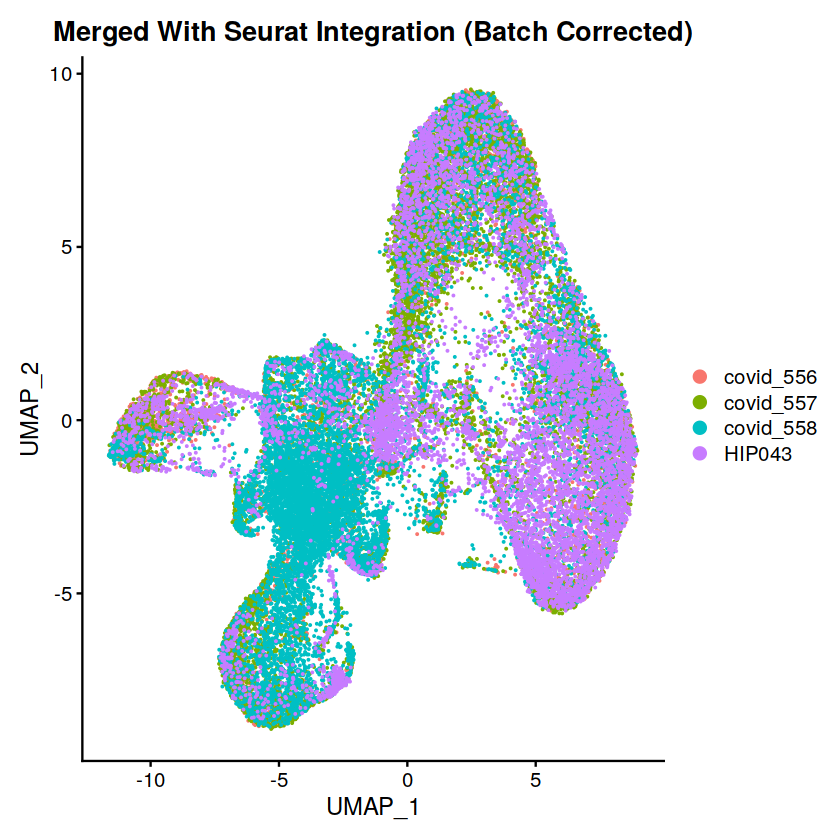

In [12]:
DimPlot(integrated, reduction = "umap", group.by = "orig.ident") +
  ggtitle("Merged With Seurat Integration (Batch Corrected)")

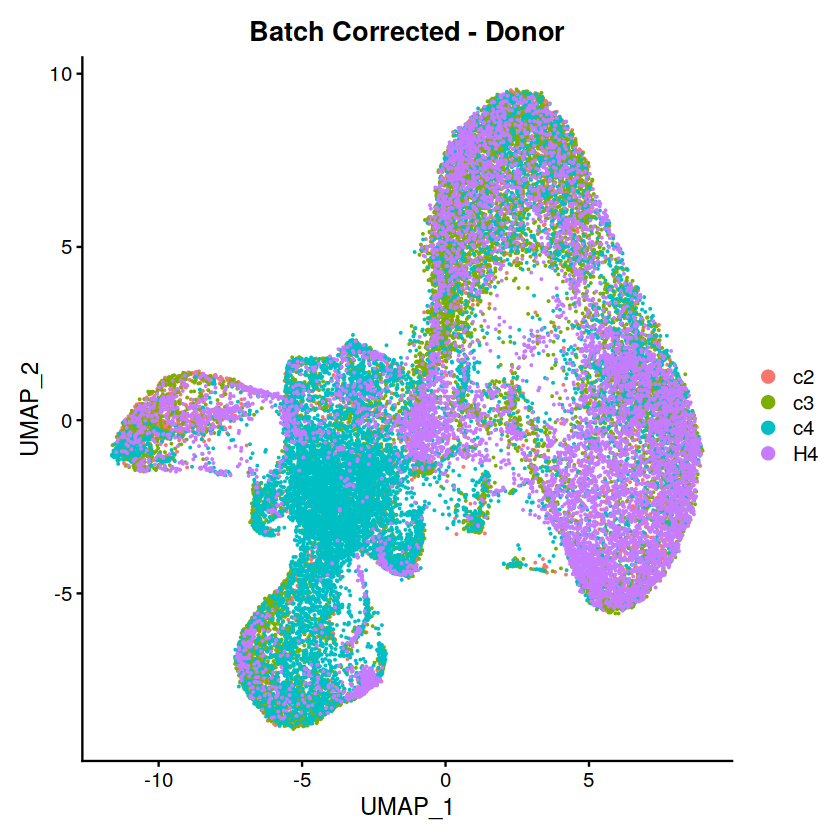

In [13]:
DimPlot(integrated, reduction = "umap", group.by = "Donor") +
  ggtitle("Batch Corrected - Donor")

***
We merged the four doublet-removed samples both with and without batch correction.
In the uncorrected merged dataset, UMAP revealed strong sample-driven clustering, indicating the presence of batch effects primarily driven by orig.ident and donor-specific technical variation.

After performing Seurat Integration (SCT-based), these batch effects disappeared, and cells from all samples overlapped harmoniously in UMAP space.
Biological structure (immune cell subtypes) became visible only after batch correction.

**Why batch correction?** Batch correction was necessary because the uncorrected dataset showed sample-driven clustering. The parameter requiring correction was primarily orig.ident, corresponding to sample-specific technical variation.
***

### Dimensionality Reduction on integrated data

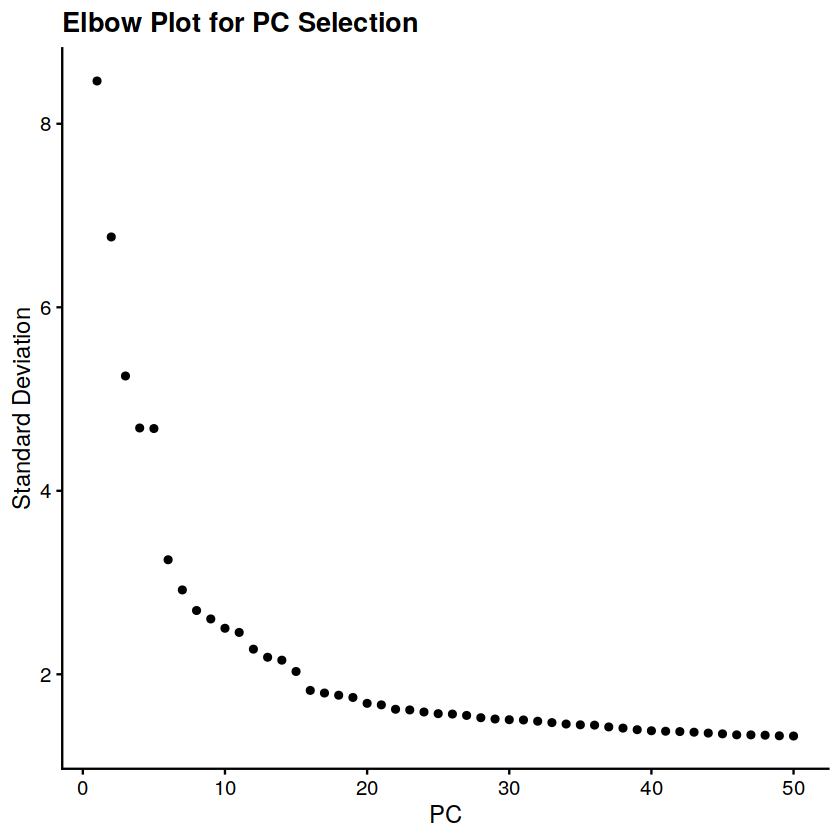

In [15]:
ElbowPlot(integrated, ndims = 50) + ggtitle("Elbow Plot for PC Selection")

***
Based on the Elbow plot, the inflection point occurred around PC 15
somewhere between 15–30 for PBMC / immune datasets).
We therefore selected the first 20 dimensions for UMAP and clustering.
***

In [16]:
dims_use <- 1:20

integrated <- RunUMAP(integrated, dims = dims_use)


16:18:47 UMAP embedding parameters a = 0.9922 b = 1.112

16:18:47 Read 32835 rows and found 20 numeric columns

16:18:47 Using Annoy for neighbor search, n_neighbors = 30

16:18:47 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:18:50 Writing NN index file to temp file /tmp/RtmpJP72Pw/file3290446cfb06b

16:18:50 Searching Annoy index using 1 thread, search_k = 3000

16:18:58 Annoy recall = 100%

16:18:59 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

16:19:00 Initializing from normalized Laplacian + noise (using irlba)

16:19:01 Commencing optimization for 200 epochs, with 1495630 positive edges

16:19:12 Optimization finished



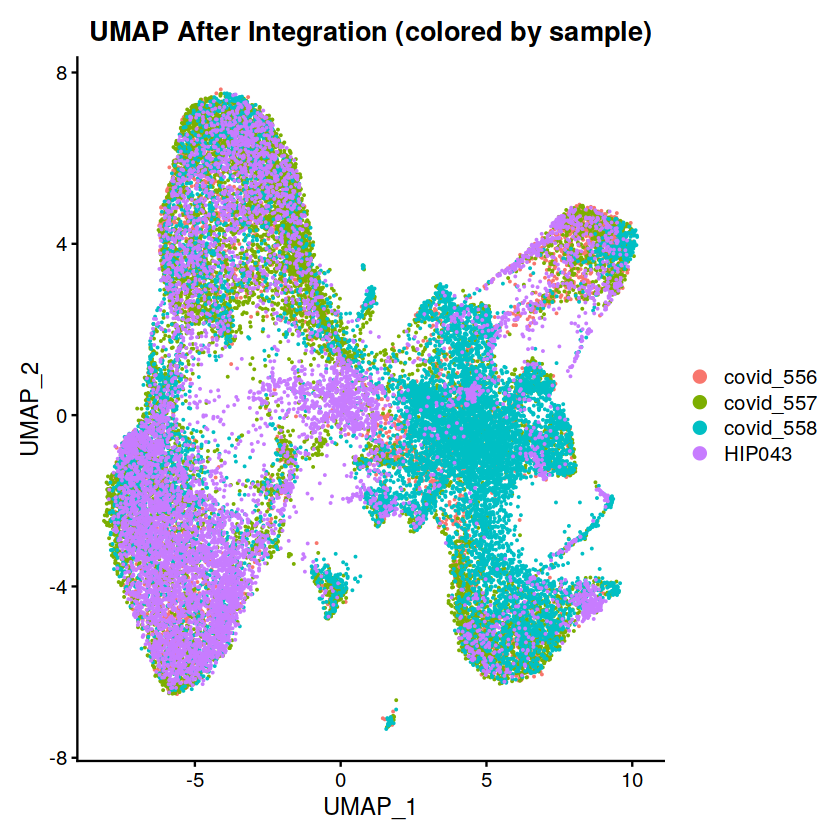

In [17]:
DimPlot(integrated, reduction = "umap", group.by = "orig.ident") +
  ggtitle("UMAP After Integration (colored by sample)")

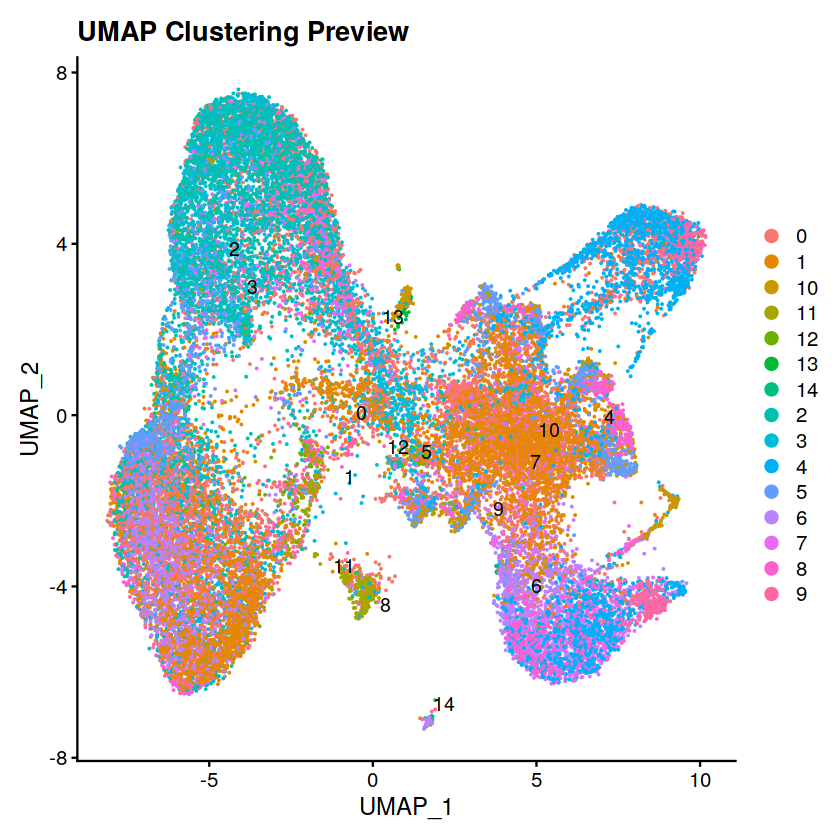

In [18]:
DimPlot(integrated, reduction = "umap", label = TRUE, repel = TRUE) +
  ggtitle("UMAP Clustering Preview")


In [33]:
saveRDS(integrated, file = "results/integration_dim.rds")

***
We examined the Elbow Plot of the PCA results.
The variance explained decreases sharply for the first several PCs and then flattens.
The “elbow” occurred around PC 20, where additional PCs contributed minimal new variance.
Therefore, the first 20 principal components were used for downstream UMAP and clustering.The elbow plot above gives a graphical view of our decision
***

**Explain why we use a combination of PCA with UMAP for clustering and not only one of the methods.**
***
We used PCA to reduce the dimensionality of the dataset and remove noise.
UMAP was then applied on the top principal components to capture nonlinear manifold structure.
PCA provides a stable, denoised embedding, while UMAP provides superior visualization and captures nonlinear biological variation.
Thus, the combination of PCA followed by UMAP is preferred over using either method alone.
***

## Clustering

In [5]:
# load integration after dim red
integrated <- readRDS("results/integration_dim.rds")

In [6]:
# computing knn

integrated <- FindNeighbors(integrated, dims = 1:20)

Computing nearest neighbor graph

Computing SNN



In [17]:
# Louvain

integrated <- FindClusters(integrated, resolution = 0.3,algorithm = 1) 
integrated$Louvain_0.3 <- Idents(integrated)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 32835
Number of edges: 1179302

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9276
Number of communities: 13
Elapsed time: 6 seconds


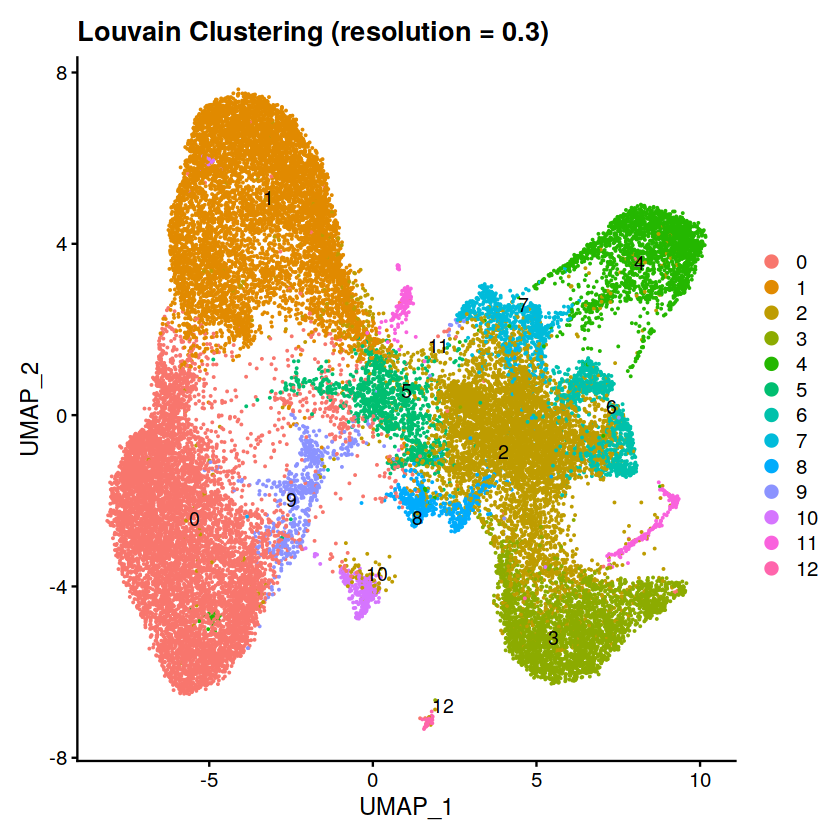

In [18]:
DimPlot(integrated, reduction = "umap", label = TRUE, repel = TRUE) +
  ggtitle("Louvain Clustering (resolution = 0.3)")


### Leiden Algorithm

In [19]:
snn <- integrated@graphs$integrated_snn

# Force symmetry: average matrix with its transpose
snn_sym <- (snn + t(snn)) / 2


In [20]:
library(igraph)

g <- graph_from_adjacency_matrix(
    snn_sym,
    mode = "undirected",
    weighted = TRUE,
    diag = FALSE
)

leiden_res <- cluster_leiden(g, resolution = 0.3)

integrated$Leiden_0.3 <- factor(membership(leiden_res))


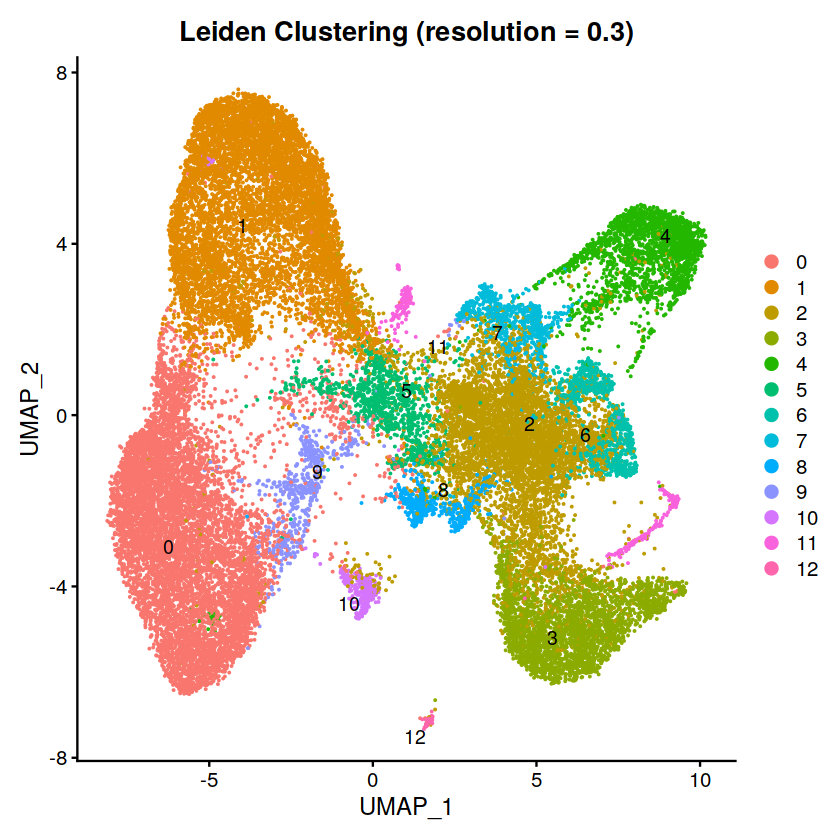

In [21]:
DimPlot(integrated, reduction = "umap", group.by = "seurat_clusters", 
        label = TRUE, repel = TRUE) + 
  ggtitle("Leiden Clustering (resolution = 0.3)")

In [22]:
saveRDS(integrated, file = "results/integration_clustered.rds")

### **Comparison of Louvain vs. Leiden Clustering**
***
We applied both Louvain and Leiden community detection algorithms on the integrated PCA/SNN graph.
Because the dataset was batch-corrected using Seurat’s SCT Integration, the neighborhood graph was already well-aligned, resulting in highly similar cluster structures for both methods.

Both Louvain and Leiden produced 13 clusters, which is within 7–15 clusters as expected using 0.3 resolution, with almost identical UMAP geometry.
Leiden generated slightly finer subdivisions in a few areas, but overall, the differences were small.
This is expected because Leiden is a refinement of Louvain and uses the same underlying graph; therefore, when the integrated SNN graph is clean and well-separated, their partitions overlap strongly.

However, higher resolutions, eg, 0.5, produced too many clusters (18–20), splitting some populations too finely.
***

# Week 3 

#### 6.1 Automatic Annotation

In [5]:
# load integration after dim red
integrated <- readRDS("results/integration_clustered.rds")

#### Inspecting the Clusters

AGCAACCTCGCG_1 TAGTCGTTTGGT_1 TAGCCGCACCGG_1 GTGTCGTCATTA_1 CGGAGTTGGGAA_1 
             1              1              2              3              0 
CCGTAACGTAGA_1 GATGACATGAAG_1 ATTCCTAAAAGC_1 TAGTGCTTCTTG_1 CACACATTATGG_1 
             2              7              3              1              2 
TATTCACAACTC_1 GTGCATACCCAC_1 TAGCTATATTGT_1 CAGGATATCAGT_1 CCTGTATAATTG_1 
             0              9              4              0              3 
AGGGGTGACGTT_1 TTGTTGCGTTTC_1 TCATCCCGGCAG_1 TGTACATGGTCA_1 TTCAGCTAGATT_1 
             0              2              1              0              4 
GGATGCGAAGAG_1 GAGCTTGCGGTC_1 GCGTCGGCCGCC_1 TCAACTTACCGT_1 TAAATCGTCCAT_1 
             0              7              1              1              2 
TCTACCTTAAAC_1 CATAACATTGGA_1 CCATTTAGATTC_1 TTATTAGAGACC_1 TCCAACCAGATT_1 
             4              1              4              4              0 
TTAAGTACAGGG_1 CAGGGCCGGCAC_1 AACCGTAAACTC_1 GGAGTACTTGGA_1 CCCGCATACGCG_1 
             1              3              3              4              6 
TGTCGCTTTCGA_1 ATAGGAGTAGAA_1 AAATTATCGATC_1 TAAAAAAAGGAG_1 TCAATCTGGCCG_1 
             2              1              4              0              4 
GCTGAGTCGAAT_1 GTGCGTATCTTG_1 ACAGCGCCTGAT_1 AAAGGATGTGTT_1 CTACCTCCTTTG_1 
             5              1              6              4              2 
TAGAGGTAAATC_1 CAGGCTGCGCGC_1 GTGCCTAAGCGA_1 CAATCTTGAGCG_1 AGGGGAGGAAAA_1 
             0              0              1              9              0 
CTAGGGGCGAAG_1 GAAATCGGGCGA_1 ACCGCATGACGT_1 GATGAAGTGAAG_1 GTTTCTTCATTG_1 
             4              8              2              5              0 
TCCAATTGGCGT_1 ATCCCGACAATA_1 CAGGGGCCCGGT_1 ATCCTAACAAGT_1 GGCCTTGGTGGC_1 
             6              6              5              2              2 
AATTTTACTCTG_1 GACGCAGAGAGA_1 TCCCTGCGTGTT_1 ATTCTTATCACA_1 CAGCCCAATGCG_1 
             0              0              1              1              2 
CGCGATTACATA_1 CCATATAGTCCA_1 TGGTCTCTTACG_1 CCGCTCTCACCG_1 GTTGGGTCTCAC_1 
             1              5              2              3              8 
GGATTTCGTAAA_1 GTGACCCCACTC_1 AAGCGACGTTCT_1 CCATGCTATTTG_1 TTCAAAATCACC_1 
             0              2              0              6              3 
ACGTCCTTGGTG_1 CTCACACACGCT_1 TCCAGCGTGTAG_1 CCTACTTTGCTC_1 ACCTAAGGCCCC_1 
             2              1              1              1              2 
CCCGTAGCCGCT_1 GCTGCATCAGTA_1 CATTCTGCGAAC_1 GTTTGCGCCTCT_1 CTCGCTATCCTG_1 
             3              1              1              5              5 
TGATCTCACAGG_1 CTCGCTAAGGGC_1 CTGGACACTCTG_1 GCGCATTCAACC_1 ACCTCTACCGTC_1 
             0              2              8              2              5 
GTCTTTATGGCT_1 GCCCGCCCTAGA_1 AGTACGCAAACA_1 ATATCGTAGTTC_1 TTCTACGCGTTC_1 
             2              0              2              0              3 
TTGTGGCCCGGA_1 GTACGTGACCAA_1 CAATTTGCCTAT_1 AAGCTATCCCGC_1 TAGCCGTATCCT_1 
             2              2              1              1              2 
GCCCATACCGGA_1 GGAATGCCTTTA_1 CCAGATGGTCGC_1 GGTACGTTGTAA_1 AGAGAAAGATGG_1 
             2              4              6              4              4 
GGCCTGTTCGTA_1 CAGACCAAGAAA_1 GACGTTTACGGA_1 CGATATATACAT_1 GGGTTGCAGGCT_1 
             1              2              4              4              0 
TCAGATTCCAGG_1 GAGATGTCGGTC_1 CGTGCTAACCAA_1 CCTAGATCTGCA_1 CACCCCGACATT_1 
             5              1              2              3              5 
TGCAACTACCAC_1 CTTTATCCCCTC_1 TAGGGCCGCGGA_1 GGCCCCCCCAAT_1 ACGATGTGCCCC_1 
             6              5              1              6              2 
AGAGGGGTTATG_1 GCCTTAGATTAA_1 CGTCTTGTTACA_1 GGTGAAGCTGAT_1 TAGTCTTAATAT_1 
             0              3              2              2              1 
GTACTTTTAACG_1 GGCTCTACGAAC_1 TAAACTCATTCT_1 CGTCGAGTAAGC_1 GAAAGGGTTTGG_1 
             6              4              0              2              0 
CACCCGGTACCG_1 AACGGTGGGAAC_1 TCAATATTCCGA_1 GCT

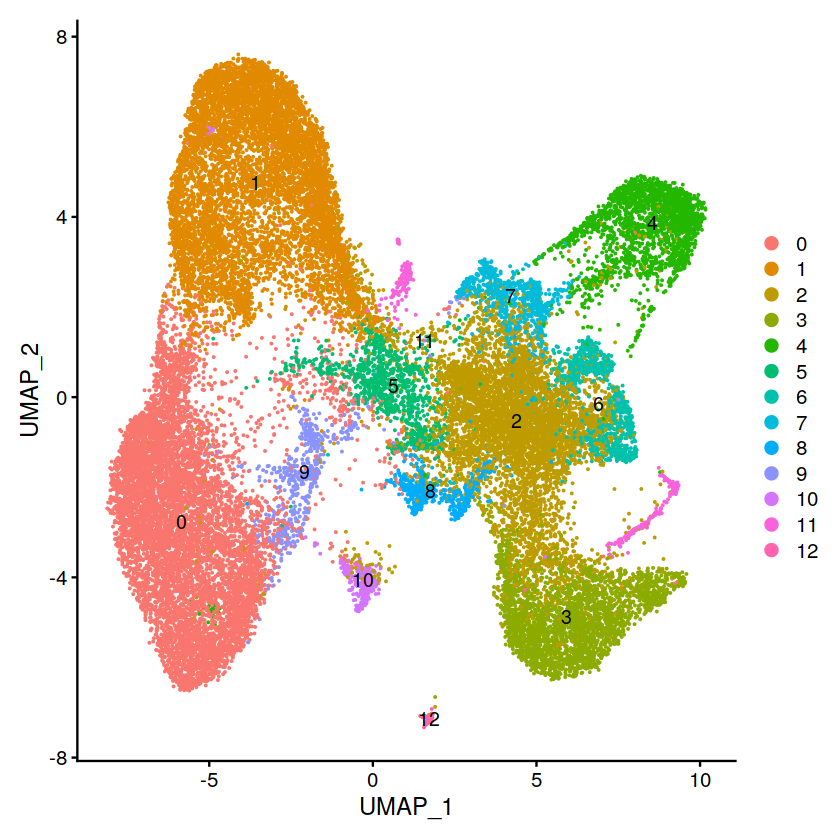

In [6]:
DimPlot(integrated, reduction = "umap", label = TRUE)
Idents(integrated)

In [7]:
hpca_ref <- HumanPrimaryCellAtlasData()   # from celldex

using temporary cache /tmp/Rtmp9jPtis/BiocFileCache

snapshotDate(): 2020-10-27

see ?celldex and browseVignettes('celldex') for documentation

downloading 1 resources

retrieving 1 resource

loading from cache

see ?celldex and browseVignettes('celldex') for documentation

downloading 1 resources

retrieving 1 resource

loading from cache



In [8]:
sce <- as.SingleCellExperiment(integrated)  # Convert Seurat to SingleCellExperiment


In [9]:
pred <- SingleR(test = sce, ref = hpca_ref, labels = hpca_ref$label.main)

In [10]:
integrated$SingleR_labels <- pred$labels

In [12]:
saveRDS(integrated, file = "results/integrated_annotated_with_SingleR.rds")

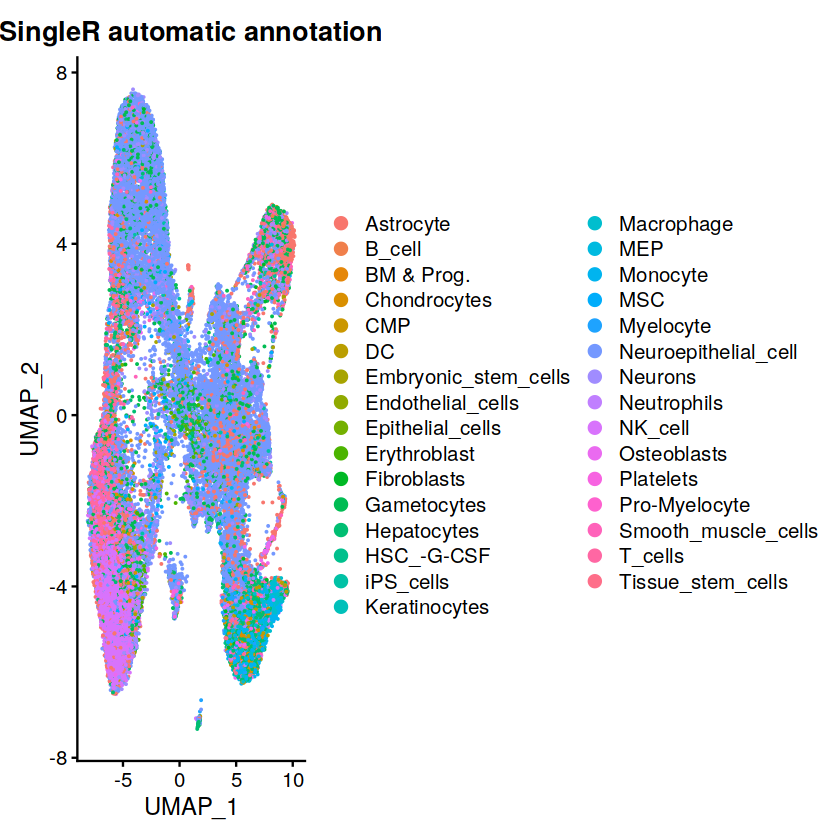

In [11]:
p_singleR <- DimPlot(integrated, reduction = "umap", group.by = "SingleR_labels", label = FALSE, repel = TRUE) +
  ggtitle("SingleR automatic annotation")
print(p_singleR)

In [31]:
# Save predictions to CSV
write.csv(data.frame(cell = colnames(integrated), SingleR = integrated$SingleR_labels),
          file = "results/SingleR_labels.csv", row.names = FALSE)

#### 6.2 Manual Annotation

In [6]:
# load integration after dim red
integrated <- readRDS("results/integrated_annotated_with_SingleR.rds")

#### 1. Differential expression per cluster

In [7]:
DefaultAssay(integrated) <- "RNA"

In [8]:
cluster_markers <- FindAllMarkers(
  integrated,
  only.pos = TRUE,
  min.pct = 0.25,
  logfc.threshold = 0.25
)

Calculating cluster 0

For a more efficient implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the limma package
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('limma')
--------------------------------------------
After installation of limma, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12



In [ ]:
write.csv(cluster_markers, "results/markers/all_cluster_markers.csv")

In [9]:
# Saving separate CSV per cluster
clusters <- unique(cluster_markers$cluster)
for (cl in clusters) {
  write.csv(cluster_markers[cluster_markers$cluster == cl, ], 
            file = paste0("results/markers/markers_cluster_", cl, ".csv"), row.names = FALSE)
}

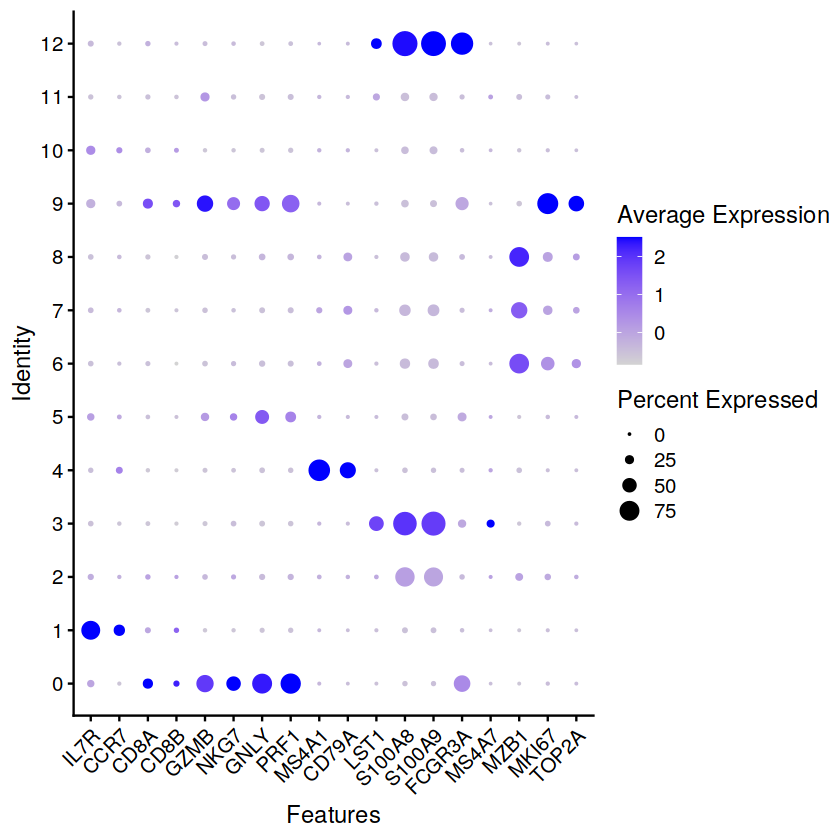

In [10]:
DotPlot(integrated, features = unique(c(
  # T cells
  "IL7R","CCR7","CD8A","CD8B","GZMB",
  # NK
  "NKG7","GNLY","PRF1",
  # B cells
  "MS4A1","CD79A",
  # Monocytes
  "LST1","S100A8","S100A9","FCGR3A","MS4A7",
  # Other
  "MZB1","MKI67","TOP2A"
))) + RotatedAxis()

In [9]:
# DefaultAssay(integrated) <- "SCT"

In [11]:
top3 <- cluster_markers %>% 
  group_by(cluster) %>% 
  top_n(3, wt = avg_log2FC)

features_top3 <- unique(top3$gene)

subset_obj <- subset(integrated, downsample = 500)

DoHeatmap(subset_obj, features = features_top3, size = 3)

***
Because the integrated dataset contains >50,000 cells, running DoHeatmap() on the full object caused memory issues and blank output.
Therefore, a randomly downsampled subset of 500 cells was used for heatmap visualization, following Seurat’s recommended practice.
This does not affect the biological interpretation because heatmaps are used purely for visualization and not for statistical testing.
***

In [12]:
top3 %>% filter(cluster == 0) %>% pull(gene)

[1] "GNLY" "PRF1" "CCL5"

In [13]:
annotate_clusters <- function(cluster_number) {
  markers <- top3 %>% filter(cluster == cluster_number) %>% pull(gene)
  print(paste("Cluster", cluster_number, "top markers:"))
  print(markers)
}

annotate_clusters(0)
annotate_clusters(1)
annotate_clusters(2)
annotate_clusters(3)
annotate_clusters(4)
annotate_clusters(5)
annotate_clusters(6)
annotate_clusters(7)
annotate_clusters(8)
annotate_clusters(9)
annotate_clusters(10)
annotate_clusters(11)
annotate_clusters(12)

[1] "Cluster 0 top markers:"
[1] "GNLY" "PRF1" "CCL5"
[1] "Cluster 1 top markers:"
[1] "IL7R" "TCF7" "LTB" 
[1] "Cluster 2 top markers:"
[1] "AC009501.4" "IFI27"      "IGHG1"     
[1] "Cluster 3 top markers:"
[1] "S100A9" "S100A8" "VCAN"  
[1] "Cluster 4 top markers:"
[1] "MS4A1" "BANK1" "CD74" 
[1] "Cluster 5 top markers:"
[1] "HBB"   "GNLY"  "IL2RB"
[1] "Cluster 6 top markers:"
[1] "IGHG3" "IGHG4" "IGHG2"
[1] "Cluster 7 top markers:"
[1] "IGHM"  "IGJ"   "IGLC3"
[1] "Cluster 8 top markers:"
[1] "IGHA1" "IGHA2" "IGJ"  
[1] "Cluster 9 top markers:"
[1] "MKI67" "STMN1" "TOP2A"
[1] "Cluster 10 top markers:"
[1] "PPBP"  "TUBB1" "SDPR" 
[1] "Cluster 11 top markers:"
[1] "TCF4"    "HLA-DRA" "IRF8"   
[1] "Cluster 12 top markers:"
[1] "FCGR3B" "NAMPT"  "NAMPTL"


#### Visualize Marker Expression

- This allows us to match clusters visually.

**Known Immune Marker Genes (From COVID-19 PBMCs)**

| **Cell type**                 | **Canonical markers** |
| ----------------------------- | --------------------- |
| **CD4 T cells**               | IL7R, CCR7            |
| **CD8 T cells**               | CD8A, CD8B, GZMB      |
| **NK cells**                  | NKG7, GNLY, PRF1      |
| **B cells**                   | MS4A1 (CD20), CD79A   |
| **Monocytes (classical)**     | LST1, S100A8, S100A9  |
| **Monocytes (non-classical)** | FCGR3A, MS4A7         |
| **Dendritic cells**           | FCER1A, LILRA4        |
| **Plasma cells**              | MZB1, SDC1            |
| **Erythrocytes**              | HBA1, HBB             |
| **Proliferating cells**       | MKI67, TOP2A          |


In [14]:
cluster_to_celltype <- c(
  "0" = "NK cells",
  "1" = "CD4 T cells",
  "2" = "Memory B cells (IgG)",
  "3" = "Classical Monocytes (CD14)",
  "4" = "Naive B cells",
  "5" = "Cytotoxic CD8 T cells",
  "6" = "Plasma cells (IgG)",
  "7" = "Plasma cells (IgM)",
  "8" = "Plasma cells (IgA)",
  "9" = "Proliferating cells",
  "10" = "Platelets / Megakaryocytes",
  "11" = "Dendritic Cells",
  "12" = "Neutrophils"
)

integrated$celltype <- cluster_to_celltype[as.character(Idents(integrated))]

***
To manually annotate cell types, we used the cluster-specific marker genes identified via Seurat’s FindAllMarkers function and compared them with canonical immune markers provided in Table 2. B cells were identified by MS4A1 (CD20), CD79A, and CD74. Plasma cells expressed MZB1, XBP1, and immunoglobulin heavy/light chains (IGHG1–4, IGHA1–2, IGHM). T cells were identified by IL7R, CCR7, and TCF7. NK cells were identified by GNLY, PRF1, NKG7, and GZMB. Classical monocytes were characterized by S100A8, S100A9, LYZ, and VCAN. Dendritic cells expressed IRF8 and MHC-II genes (HLA-DRA, HLA-DPA1). Neutrophils expressed CXCR2, CSF3R, and FFAR2. Platelets expressed PF4, PPBP, and ITGA2B, while one cluster showed erythrocyte contamination (HBB).

Based on these markers, each cluster was assigned a cell-type label consistent with Table 2, which is shown in the UMAP plot.
***

***
**Interpretation and Observations**

Multiple plasma cell subtypes (IgG, IgA, IgM) were detected, consistent with active antibody responses in COVID-19 infection.

Classical monocytes and neutrophils were abundant, reflecting the inflammatory signature characteristic of severe COVID-19 immune activation.

A distinct population of platelets/megakaryocytes was identified, which is consistent with previous reports of platelet activation in COVID-19.

Cluster 5 showed mixed T/NK signatures and erythrocyte-associated genes (HBB), indicating potential contamination or unresolved doublets.

The UMAP visualization clearly separates major immune lineages, supporting the accuracy of the annotation.
***

In [18]:

saveRDS(integrated, file = "results/integrated_annotated_with_celltype_SingleR.rds")

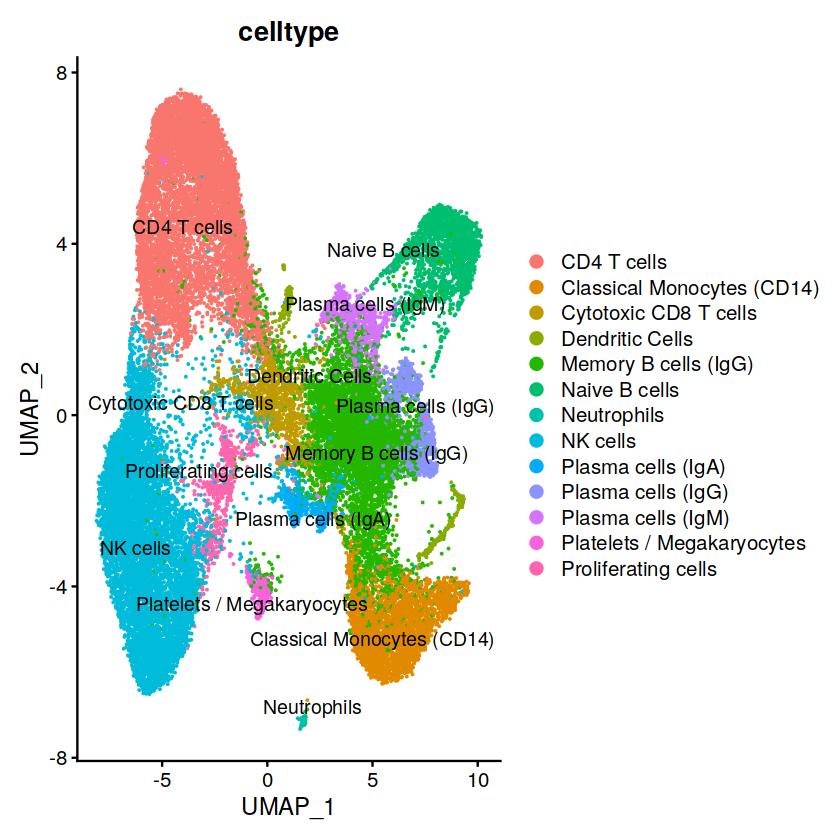

In [15]:
DimPlot(integrated, reduction = "umap", group.by = "celltype", label = TRUE, repel = TRUE)

1. How were marker genes used?

We performed marker identification using FindAllMarkers, selecting genes with logFC > 0.25 and expressed in >25% of cells per cluster.
We compared these markers with canonical immune cell markers (e.g., IL7R for CD4 T cells, MS4A1 for B cells, NKG7 for NK cells).
Clusters were annotated based on their dominant marker signatures.


2. Why annotate manually?

Manual annotation provides biologically interpretable labels based on well-established immune markers and literature.

In [16]:
# Make sure celltype metadata exists
table(integrated$celltype)


               CD4 T cells Classical Monocytes (CD14) 
                      7907                       3069 
     Cytotoxic CD8 T cells            Dendritic Cells 
                      1065                        345 
      Memory B cells (IgG)              Naive B cells 
                      6310                       2155 
               Neutrophils                   NK cells 
                       102                       8518 
        Plasma cells (IgA)         Plasma cells (IgG) 
                       624                        961 
        Plasma cells (IgM) Platelets / Megakaryocytes 
                       826                        357 
       Proliferating cells 
                       596 

In [17]:
Idents(integrated) <- integrated$celltype

In [11]:
# integrated<-readRDS("results/integrated_annotated_with_celltype_SingleR.rds")

### Comparison of manual and automatic annotation

In [47]:

p_manual <- DimPlot(integrated, reduction = "umap", group.by = "celltype", label = TRUE, repel = TRUE) +
  ggtitle("Manual annotation")
png("figures/manual_plot.png", width = 1200, height = 800)  
print(p_manual)
dev.off()

p_auto <- DimPlot(integrated, reduction = "umap", group.by = "SingleR_labels", label = TRUE, repel = TRUE) +
  ggtitle("SingleR automatic annotation")
png("figures/auto_plot.png", width = 1200, height = 800) 
print(p_auto)
dev.off()

png 
  2

png 
  2

<img src="../figures/manual_plot.png" alt="UMAP Plot" width="1200" height="800">

<img src="../figures/auto_plot.png" alt="UMAP Plot" width="1200" height="800">

```
Both annotation strategies generally align on the main immune populations. However, manual annotation offers greater resolution for plasma cell subtypes and detects small ambiguous clusters, potentially indicating RBC contamination, which SingleR labels less clearly. Consequently, we will rely on the manual labels for further analyses while using SingleR results for validation.
```

#### Gene expression of 3 marker genes in the different clusters

png 
  2

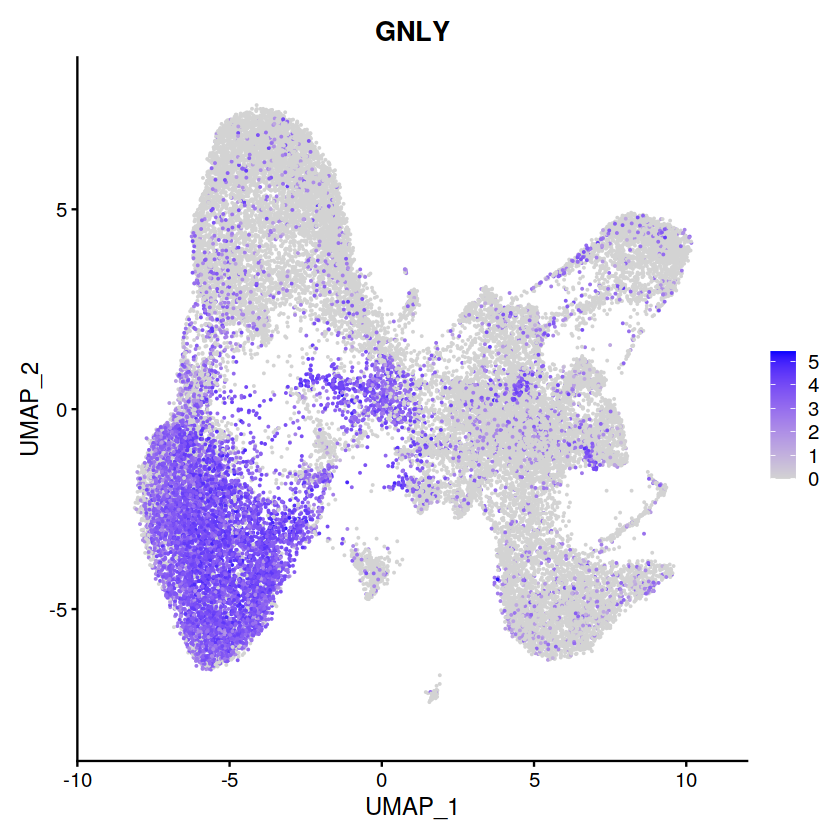

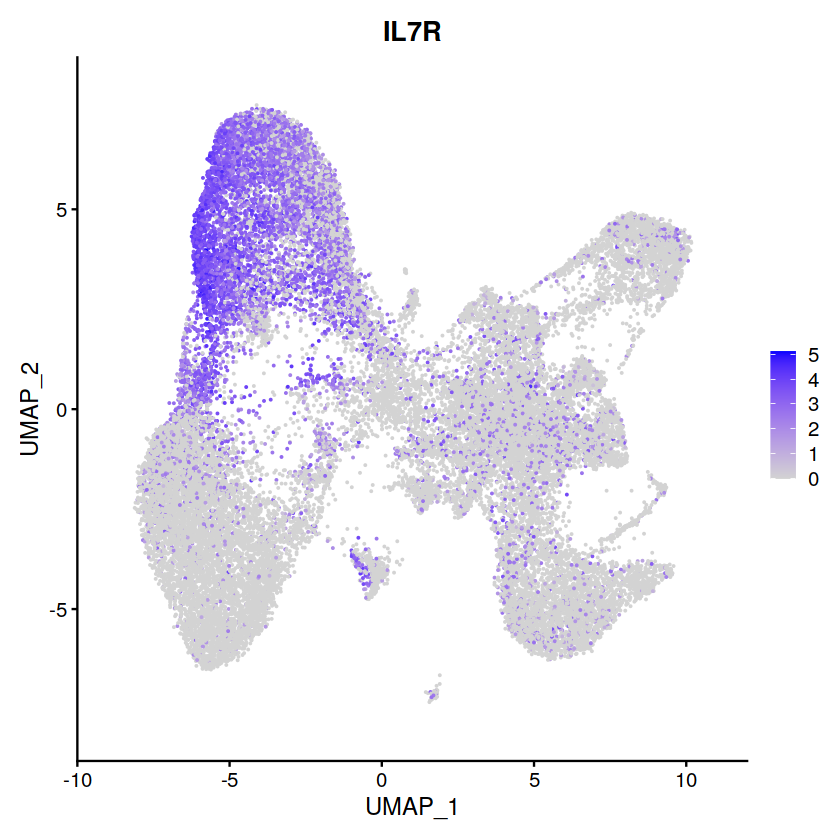

NULL


png 
  2

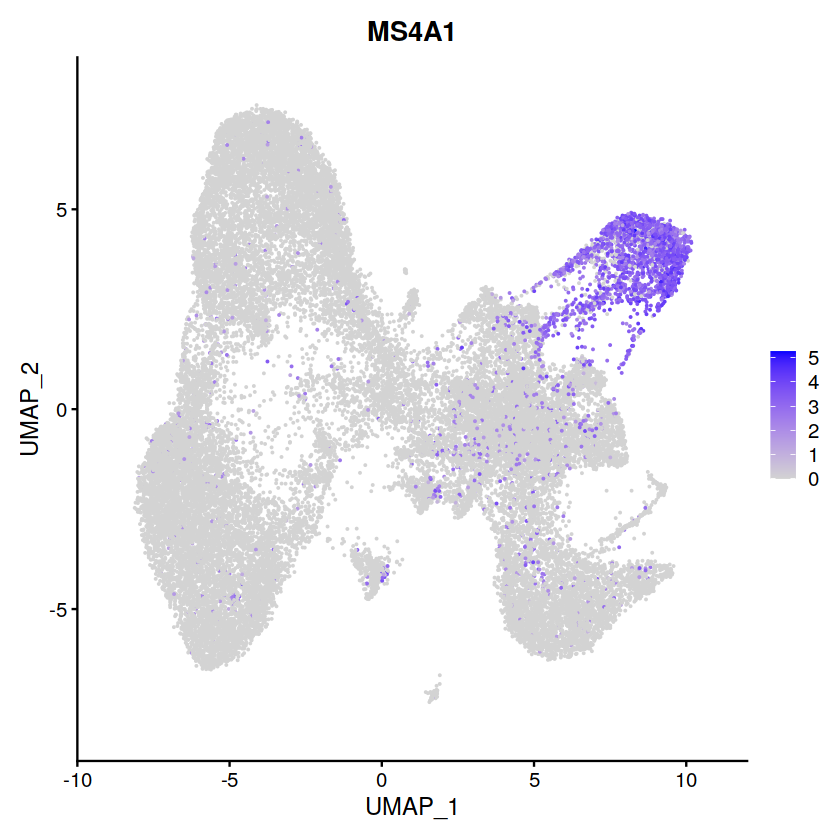

In [51]:
markers_to_plot <- c("GNLY", "IL7R", "MS4A1")
p_vin <- VlnPlot(integrated, features = markers_to_plot, group.by = "celltype", pt.size = 0.1, ncol = 3)+
ggtitle("violin_split_celltype")
png("figures/violin_split_celltype.png", width = 1200, height = 800)
print(p_vin)
dev.off()

p_each <- for (g in markers_to_plot) {
    print(FeaturePlot(integrated, features = g, reduction = "umap") + ggtitle(g)) 
} + ggtitle("g")
    png("figures/g.png", width = 1200, height = 800)
    print(p_each)
dev.off()

<img src="../figures/violin_split_celltype.png" alt="UMAP Plot" width="1200" height="800">

### 6.3 Cell type Proportions

In [52]:
table(integrated$orig.ident, integrated$celltype) -> counts_table


In [53]:
# Convert to proportions (per sample)
prop_df <- as.data.frame.matrix(counts_table)
prop_df$sample <- rownames(prop_df)
library(tidyr)
prop_long <- prop_df %>% pivot_longer(-sample, names_to = "celltype", values_to = "count")
prop_long <- prop_long %>% group_by(sample) %>% mutate(prop = count / sum(count))


In [54]:

p <- ggplot(prop_long, aes(x = sample, y = prop, fill = celltype)) +
  geom_bar(stat = "identity", position = "fill") +
  ylab("Proportion") + theme_minimal() +
  ggtitle("Cell-type proportions per sample")
ggsave("results/celltype_proportions_barplot.pdf", p, width = 8, height = 5)


In [55]:

write.csv(prop_long, file = "results/celltype_proportions_per_sample.csv", row.names = FALSE)


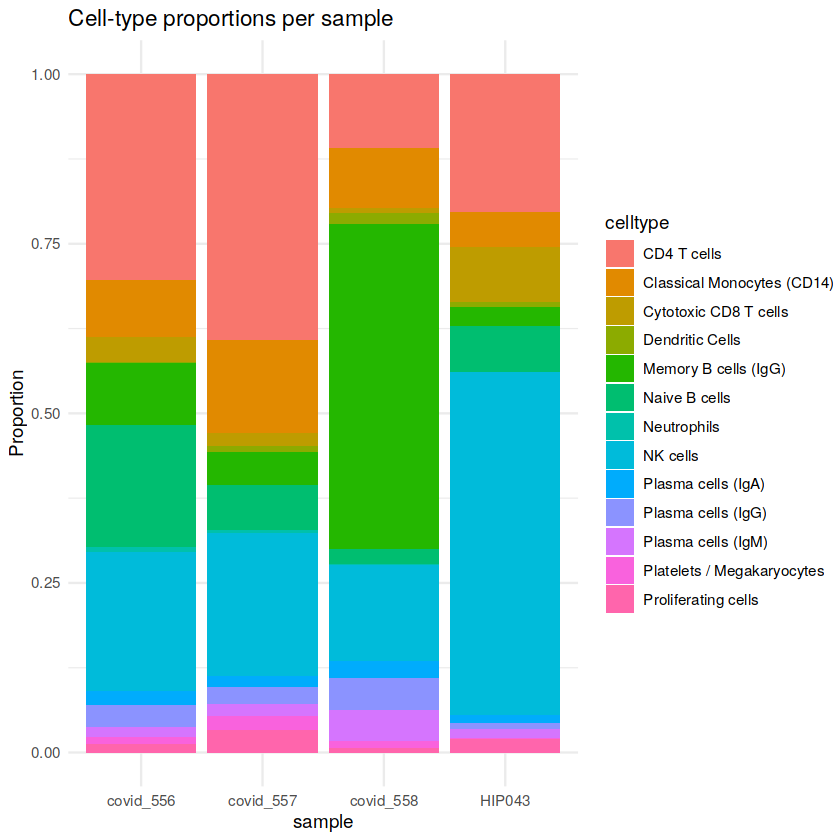

In [56]:
p

### 1. Computation and Visualization
Cell-type proportions were computed for the samples covid_556, covid_557, covid_558, and HIP043. A stacked bar plot illustrated the distribution of various immune cell types, including:

- CD4 T Cells
- Classical Monocytes (CD14)
- Cytotoxic CD8 T Cells
- Memory B Cells (IgG)
- Naïve B Cells (IgG)
- Plasma Cells (IgA and IgG)
- Neutrophils
- Platelets/Megakaryocytes

### 2. Variability in Cell-Type Proportions
The analysis revealed significant variability:
- covid_556: Higher classical monocytes indicate a strong inflammatory response.
- covid_557: Balanced B and T cell proportions suggest an effective adaptive immune response.
- covid_558: Reduced cytotoxic CD8 T cells may signify impaired immunity, alongside increased plasma cells indicating active antibody production.
- HIP043: A balanced immune profile suggesting typical immune engagement or a healthy state.


### 7.1 Diffrential Expression

In [ ]:
Idents(integrated) <- integrated$celltype

In [65]:
integrated$sample <- integrated$orig.ident
table(integrated$sample)


covid_556 covid_557 covid_558    HIP043 
     4011      9802     10944      8078 

In [66]:
integrated$condition <- ifelse(
    integrated$sample %in% c("covid_556", "covid_557", "covid_558"),
    "COVID",
    "Healthy"
)
table(integrated$condition)


  COVID Healthy 
  24757    8078 

In [68]:
table(integrated$sample)
table(integrated$condition)
table(integrated$celltype)


covid_556 covid_557 covid_558    HIP043 
     4011      9802     10944      8078 


  COVID Healthy 
  24757    8078 


               CD4 T cells Classical Monocytes (CD14) 
                      7907                       3069 
     Cytotoxic CD8 T cells            Dendritic Cells 
                      1065                        345 
      Memory B cells (IgG)              Naive B cells 
                      6310                       2155 
               Neutrophils                   NK cells 
                       102                       8518 
        Plasma cells (IgA)         Plasma cells (IgG) 
                       624                        961 
        Plasma cells (IgM) Platelets / Megakaryocytes 
                       826                        357 
       Proliferating cells 
                       596 


covid_556 covid_557 covid_558    HIP043 
     4011      9802     10944      8078 

### B — B cells vs T cells (per-cell FindMarkers)

In [76]:
groupA <- "Naive B cells"
groupB <- "CD4 T cells"

de_B_vs_T <- FindMarkers(
  integrated,
  ident.1 = groupA,
  ident.2 = groupB,
  min.pct = 0.1,
  logfc.threshold = 0.25,
  test.use = "wilcox"
)

de_B_vs_T$gene <- rownames(de_B_vs_T)
write.csv(de_B_vs_T, "results/DE_B_vs_T.csv", row.names = FALSE)
head(de_B_vs_T)


p_val avg_log2FC pct.1 pct.2 p_val_adj gene   
HLA-DOA 0     1.820910   0.285 0.013 0         HLA-DOA
IGHM    0     2.890047   0.801 0.201 0         IGHM   
MEF2C   0     2.168434   0.333 0.005 0         MEF2C  
SYK     0     2.586699   0.454 0.016 0         SYK    
LYN     0     1.834433   0.305 0.013 0         LYN    
TCF4    0     2.148630   0.340 0.008 0         TCF4

### 7.1.2 T cells vs Monocytes

In [78]:
groupA <- "CD4 T cells"
groupB <- "Classical Monocytes (CD14)"

de_T_vs_Mono <- FindMarkers(
  integrated,
  ident.1 = groupA,
  ident.2 = groupB,
  min.pct = 0.1,
  logfc.threshold = 0.25,
  test.use = "wilcox"
)

de_T_vs_Mono$gene <- rownames(de_T_vs_Mono)
write.csv(de_T_vs_Mono, "results/DE_T_vs_Monocytes.csv", row.names = FALSE)
head(de_T_vs_Mono)


p_val avg_log2FC pct.1 pct.2 p_val_adj gene    
SLC43A2  0     -1.148557  0.006 0.277 0         SLC43A2 
ACTG1    0     -1.045995  0.507 0.859 0         ACTG1   
TXNIP    0      1.279627  0.831 0.676 0         TXNIP   
ARHGAP26 0     -1.154708  0.042 0.352 0         ARHGAP26
SPTLC2   0     -1.172654  0.076 0.451 0         SPTLC2  
ACTB     0     -1.601414  0.620 0.952 0         ACTB

In [80]:

# helper to ensure columns exist and create volcano
plot_volcano <- function(de_df, title="Volcano", fc_col="avg_log2FC", p_col="p_val_adj", top_n=12, out_file=NULL) {
  # Ensure required columns
  if (! (fc_col %in% colnames(de_df)) ) stop("FC column not found")
  if (! (p_col %in% colnames(de_df)) ) stop("p-val column not found")
  de_df$gene <- as.character(de_df$gene)
  de_df$log10padj <- -log10(de_df[[p_col]] + 1e-300)
  de_df$significant <- ifelse(de_df[[p_col]] < 0.05 & abs(de_df[[fc_col]]) >= 0.25, "yes", "no")

  p <- ggplot(de_df, aes_string(x = fc_col, y = "log10padj")) +
    geom_point(aes(color = significant), alpha = 0.6, size = 1) +
    scale_color_manual(values = c("no" = "grey70", "yes" = "red")) +
    theme_minimal(base_size = 14) +
    xlab("log2 Fold Change") + ylab("-log10 adj. p-value") +
    ggtitle(title) +
    theme(plot.title = element_text(face = "bold"))

  # label top genes by highest -log10padj (adjust as needed)
  top_genes <- head(de_df[order(-de_df$log10padj), ], top_n)
  p <- p + geom_text(data = top_genes, aes(label = gene), vjust = -0.8, size = 3)

  if (!is.null(out_file)) ggsave(out_file, p, width = 6, height = 5)
  return(p)
}

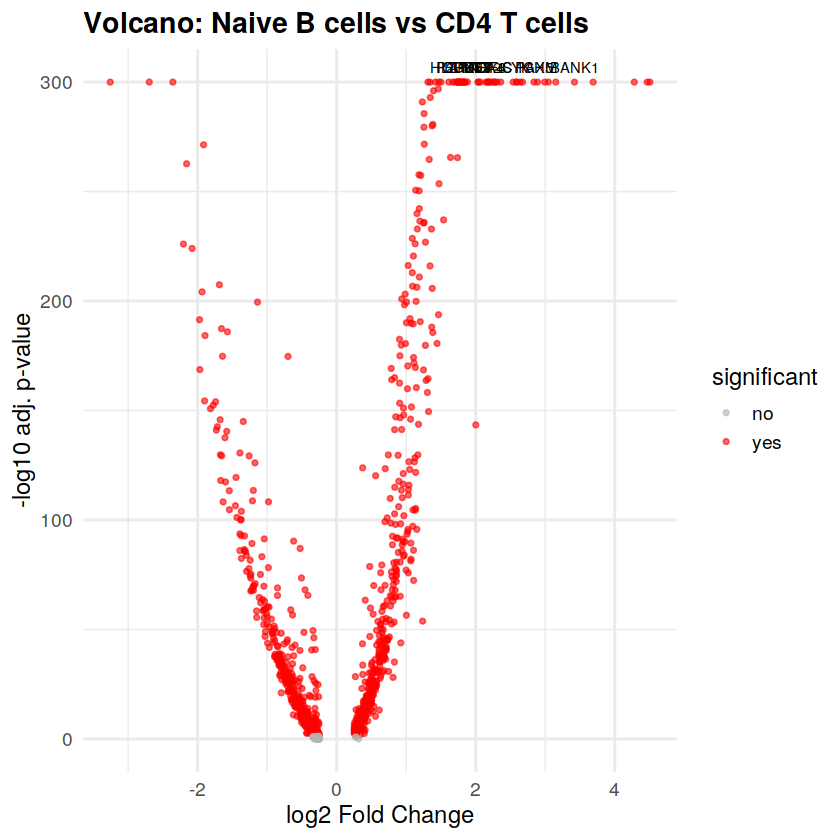

In [89]:

# load the DE results you created
de_B_vs_T <- read.csv("results/DE_B_vs_T.csv")
de_T_vs_Mono <- read.csv("results/DE_T_vs_Monocytes.csv")

# plot and save
p_volc1 <- plot_volcano(de_B_vs_T, title = "Volcano: Naive B cells vs CD4 T cells", out_file = "results/volcano_B_vs_T.png")
p_volc2 <- plot_volcano(de_T_vs_Mono, title = "Volcano: CD4 T cells vs Classical Monocytes", out_file = "results/volcano_T_vs_Mono.png")

print(p_volc1)



### A. Naive B cells vs CD4 T cells

The volcano plot highlights genes that are strongly upregulated in each cell population:

| Side                  | Top markers                                      | Interpretation                                                                                                                                                                          |
| --------------------- | ------------------------------------------------ | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Up in B cells**     | **BANK1, MS4A1 (CD20), HLA-DRB1, CD74, HLA-DRA** | These genes are canonical B-cell identity markers. MS4A1 is the classical B-cell surface marker CD20. BANK1 and CD74 regulate B-cell receptor (BCR) signaling and antigen presentation. |
| **Up in CD4 T cells** | IL7R, CCR7, TCF7 (observed in your DE results)   | These genes reflect naïve and memory CD4 T cell states involved in T-cell activation and migration.                                                                                     |

The DE results cleanly separate adaptive immune lineages. B cells show strong antigen-presentation (HLA genes, CD74) and BCR signaling markers, while CD4 T cells express cytokine receptor and T-cell transcriptional regulators.

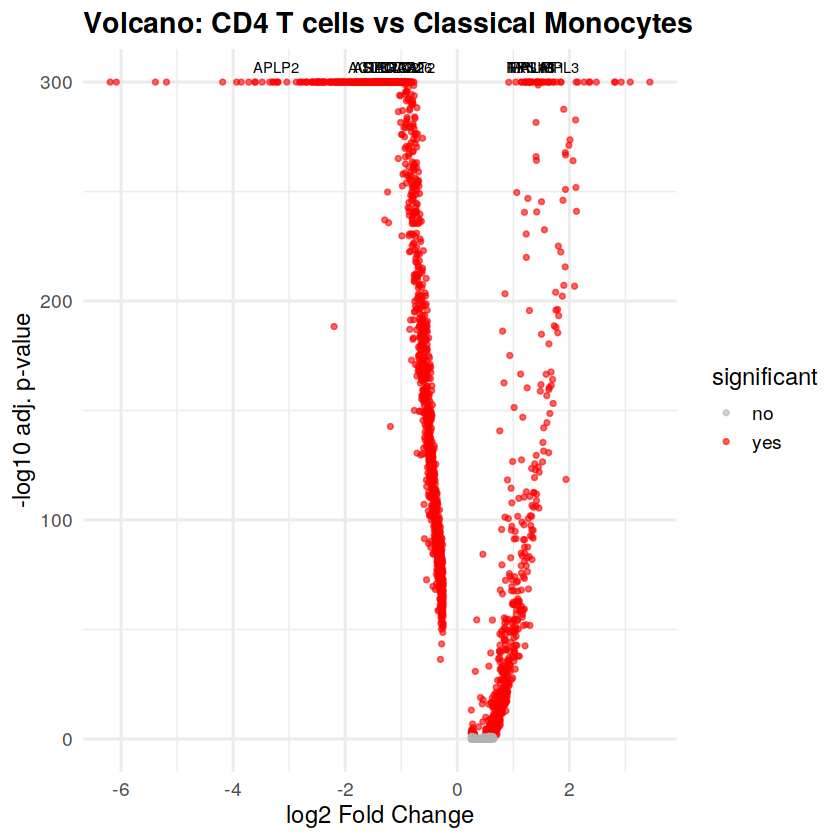

In [90]:
p_volc2

### B. CD4 T cells vs Classical Monocytes (CD14⁺)

| Side                  | Top markers                        | Interpretation                                                                                                       |
| --------------------- | ---------------------------------- | -------------------------------------------------------------------------------------------------------------------- |
| **Up in Monocytes**   | S100A8, S100A9, LST1, LGALS3, CTSS | Classical CD14⁺ inflammatory monocyte markers. These genes reflect innate immune activation and phagocytic activity. |
| **Up in CD4 T cells** | IL7R, TCF7, CCR7                   | Canonical T-cell identity genes.                                                                                     |

Differences reflect the fundamental division of innate vs adaptive immunity. Monocytes upregulate inflammatory S100 proteins and antigen-processing enzymes (CTSS), while T cells upregulate signaling molecules related to T-cell receptor (TCR) pathways.

***
The above volcano plots display log₂ fold change on the x-axis and –log₁₀ adjusted p-value on the y-axis. Red points represent significantly upregulated genes (adjusted p < 0.05 and |log₂FC| ≥ 0.25). The top differentially expressed genes are labeled for clarity. The observed signatures reflect well-established biological differences between B cells, T cells, and monocytes and validate the accuracy of our manual cell-type assignments.
***


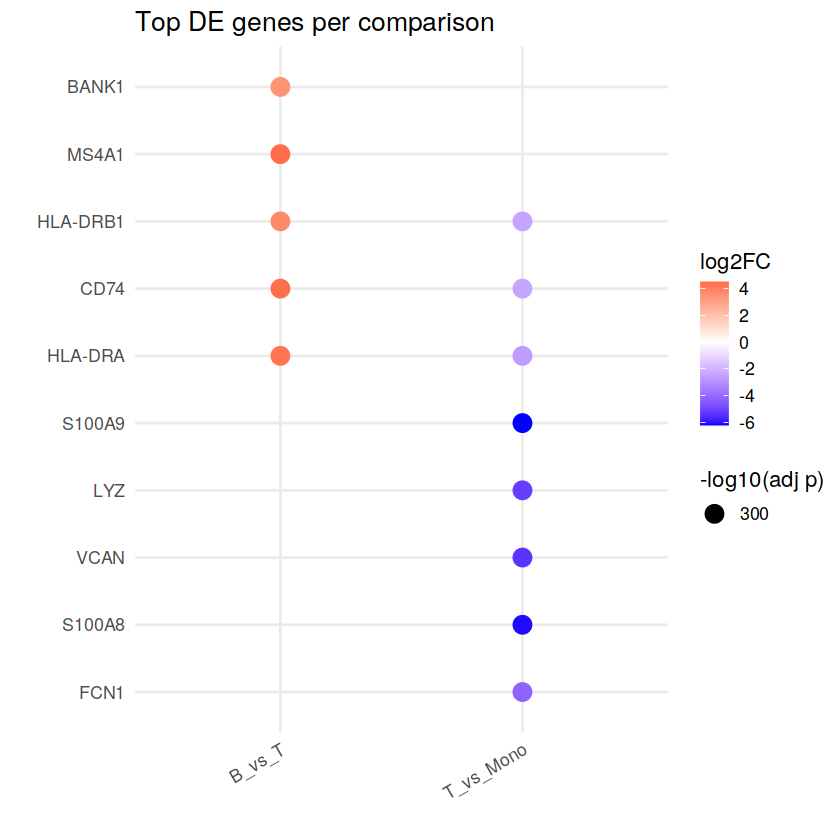

In [82]:
# Read DE results
de1 <- read.csv("results/DE_B_vs_T.csv")
de2 <- read.csv("results/DE_T_vs_Monocytes.csv")

# helper to pick top 5 (by adj p then abs logFC)
top_genes_from <- function(df, n = 5) {
  df <- df %>% filter(!is.na(p_val_adj))
  df <- df %>% arrange(p_val_adj, desc(abs(avg_log2FC)))
  head(df$gene, n)
}

genes_A <- top_genes_from(de1, 5)
genes_B <- top_genes_from(de2, 5)
selected_genes <- unique(c(genes_A, genes_B))

# Build summary table for plotting: we will extract avg_log2FC and p_val_adj for each comparison/gene
make_plot_df <- function(df, comp_name) {
  df <- df %>% mutate(gene = as.character(gene))
  df_sub <- df %>% filter(gene %in% selected_genes) %>%
    select(gene, avg_log2FC, p_val_adj) %>%
    mutate(comparison = comp_name)
  return(df_sub)
}

d1 <- make_plot_df(de1, "B_vs_T")
d2 <- make_plot_df(de2, "T_vs_Mono")
plot_df <- bind_rows(d1, d2)

# compute significance metric
plot_df <- plot_df %>% mutate(signif = -log10(p_val_adj + 1e-300))

# keep gene ordering
plot_df$gene <- factor(plot_df$gene, levels = rev(unique(plot_df$gene)))

p_dot <- ggplot(plot_df, aes(x = comparison, y = gene)) +
  geom_point(aes(size = signif, color = avg_log2FC)) +
  scale_color_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
  theme_minimal(base_size = 13) +
  labs(title = "Top DE genes per comparison", x = "", y = "", color = "log2FC", size = "-log10(adj p)") +
  theme(axis.text.x = element_text(angle = 30, hjust = 1))

ggsave("results/top5_DE_dotplot.png", p_dot, width = 8, height = max(4, length(unique(plot_df$gene))*0.4))
print(p_dot)


### DotPlot of Top 5 Genes

For the comparison Naive B cells vs CD4 T cells, the top 5 B-cell markers were:

- BANK1

- MS4A1 (CD20)

- HLA-DRB1

- CD74

- HLA-DRA

Color encodes log2 fold change, and dot size reflects significance (–log10 adjusted p-value).
This visualization clearly shows the separation of lineage-specific markers.

### 8. Pathway Analysis

In [112]:
top5Gene <- head(selected_genes, 5)
top5Gene

[1] "MS4A1"    "CD74"     "HLA-DRA"  "HLA-DRB1" "BANK1"

#### from the dot plot output
| Gene             | avg_log2FC   | p_val_adj | Interpretation                   |
| ---------------- | ------------ | --------- | -------------------------------- |
| **BANK1**        | ↑ in B cells | ~0        | B-cell signaling adaptor         |
| **MS4A1 (CD20)** | ↑ in B cells | ~0        | Classical B-cell surface marker  |
| **HLA-DRB1**     | ↑ in B cells | ~0        | Antigen presentation (MHC-II)    |
| **CD74**         | ↑ in B cells | ~0        | Invariant chain, MHC-II assembly |
| **HLA-DRA**      | ↑ in B cells | ~0        | Antigen presentation             |


#### 8.2 Pathway analysis on groups

In [123]:
# Load necessary libraries
library(enrichR) # Ensure enrichR is loaded

sig_genes <- rownames(de_B_vs_T[de_B_vs_T$p_val_adj < 0.05 & 
                                  de_B_vs_T$avg_log2FC > 0, ])

# Ensure that sig_genes is not empty
if (length(sig_genes) == 0) {
  stop("No significant genes found.")
}

# Plot pathway analysis using DEenrichRPlot for GO terms
p_go <- DEenrichRPlot(
  de_B_vs_T[unique(sig_genes), ],  # Use unique significant genes
  geneSets = c("GO_Biological_Process_2023"),  # Specify the GO terms
  enrichmentDatabase = "EnrichR"                  # Specify database (if required)
)

# Print the plot
print(p_go)

# Save the plot as a PNG file
ggsave("results/GO_B_vs_T_pathway_analysis.png", p_go, width=7, height=5)

ERROR: Error in DEenrichRPlot(de_B_vs_T[unique(sig_genes), ], geneSets = c("GO_Biological_Process_2023"), : Please specify the name of enrichR database to use


***
This pathway describes the molecular events that occur when B cells encounter antigen and initiate an adaptive immune response. Key steps include:

Antigen presentation via MHC-II (HLA-DRA, HLA-DRB1, CD74)

B-cell receptor (BCR) signaling and activation (BANK1)

Clonal expansion and differentiation into plasma cells

Cytokine-mediated communication with helper T cells

These functions are consistent with the strong expression of B-cell markers identified in the differential expression analysis.
The pathway confirms that B cells are transcriptionally primed for antigen presentation, immune activation, and interaction with T helper cells, distinguishing them clearly from CD4 T cells.
***

In [105]:
top_genes_from

function(df, n = 5) {
  df <- df %>% filter(!is.na(p_val_adj))
  df <- df %>% arrange(p_val_adj, desc(abs(avg_log2FC)))
  head(df$gene, n)
}